## Imports, data, checks

In [1]:
import numpy as np
import requests
import pandas as pd
import bokeh
import datetime
import colorcet as cc
import json
import itertools
import time
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime as dt, date
from jinja2 import Environment, FileSystemLoader
from urllib.request import urlopen
from bokeh.models import CategoricalColorMapper, NumeralTickFormatter, HoverTool, NumberFormatter, ColorBar, LinearColorMapper, BasicTicker, ColorBar
from bokeh.models import ColumnDataSource, Grid, LinearAxis, Plot, VBar, Range1d, Span, BoxAnnotation, Label, LabelSet, DataTable, DateFormatter, TableColumn, CDSView, GroupFilter
from bokeh.models.widgets import HTMLTemplateFormatter
from bokeh.plotting import output_notebook, figure
from bokeh.io import reset_output, show, output_file, save, curdoc
from bokeh.layouts import column, row, gridplot
from bokeh.palettes import *
from bokeh.transform import linear_cmap, transform
from bokeh.embed import autoload_static, components, json_item
from bokeh.resources import CDN, INLINE


The vaccine, cases, and deaths source data were relatively easy to grab diretly from the [Larimer county dashboard](https://www.larimer.org/health/communicable-disease/coronavirus-covid-19/larimer-county-positive-covid-19-numbers#/app?tab=risk) as the CSVs download through urls.

In [2]:
larimer_vac_source = pd.read_csv(
    'https://speedtest.larimer.org/covid/index.php?file=vaccinations&csv')

larimer_cases_source = pd.read_csv(
    'https://speedtest.larimer.org/covid/cases.csv', parse_dates=['ReportedDate'])

larimer_deaths_source = pd.read_csv(
    'https://larimer-county-data-lake.s3-us-west-2.amazonaws.com/Public/covid/covid_deaths.csv?t=1631890252549')


The hospitalization data was much more tricky (at least finding a simple solution was tricky) I spent several hours in webscraping research and attempts purgatory. I checked BeautifulSoup, html5lib, lxml, etc. in multiple combinations and none of them had straightforward solutions because the table for hospitalizations is actually rendered through javascript so there is nothing to scrape without actually clicking the buttons. I started down the Selenium and phantomjs path but it seemed like a nightmare. I found this lifesaving article at [Towards Data Science](https://towardsdatascience.com/data-science-skills-web-scraping-javascript-using-python-97a29738353f) which shows how to find specific XHR request urls in the browser developer tools. The requested URL for the rendered table is a pretty vanilla json and not behind any authorization so there is a pretty clean way to get to it. Praise Satan I didn't have to use Selenium.  

In [3]:
url = 'https://larimer-county-data-lake.s3-us-west-2.amazonaws.com/Public/covid/covid_patient_trend.json?t=1632506827395'

response = urlopen(url)
json_data = response.read().decode('utf-8', 'replace')

d = json.loads(json_data)
larimer_hosp_source = pd.json_normalize(d['data'])


Update 3/2022 - and they changed the hospitalization data source anyway. I was getting suspicious becuase it has been zero since late February. It looks like they were having trouble with regular daily reporting so they switched to pulling the HHS data, which aggregates admissions over the previous seven days. I'm going to add a separate df and viz starting here for the sake of preserving the previous one. larimer country also reports as per/100k, I'm going to undo that for real numbers.

In [4]:
larimer_new_hosp_source = pd.read_csv('https://speedtest.larimer.org/covid/index.php?file=hosp')

larimer_new_hosp_source.rename(columns = {'Larimer':'Hospitalizations/100k (7-day)'}, inplace = True)


larimer_new_hosp_source

date Hospitalizations/100k (7-day)
0    3/17/20                     1.6623261
1    3/18/20                     2.2164349
2    3/19/20                     2.4934892
3    3/20/20                      3.878761
4    3/21/20                      3.878761
..       ...                           ...
789  5/27/22                   1.108217432
790  5/28/22                   0.831163074
791  5/29/22                   1.939380506
792  5/30/22                   2.770543581
793  5/31/22                   3.047597939

[794 rows x 2 columns]

In [5]:
# make .csv backups of source data

larimer_vac_source.to_csv('larimer_vac_backup.csv')

larimer_cases_source.to_csv('larimer_cases_backup.csv')

larimer_deaths_source.to_csv('larimer_deaths_backup.csv')

larimer_hosp_source.to_csv('larimer_hosp_backup.csv')

larimer_new_hosp_source.to_csv('larimer_new_hosp_backup.csv')


Re-read the backup CSVs so that the notebook runs locally from this point forward.

In [6]:
larimer_vac = pd.read_csv('larimer_vac_backup.csv')

larimer_cases = pd.read_csv('larimer_cases_backup.csv')

larimer_deaths = pd.read_csv('larimer_deaths_backup.csv')

larimer_hosp = pd.read_csv('larimer_hosp_backup.csv')

larimer_new_hosp = pd.read_csv('larimer_new_hosp_backup.csv', parse_dates={'Date':[1]})

So now we have all of our dataframes

In [7]:
display(larimer_vac)

display(larimer_cases)

display(larimer_deaths)

display(larimer_hosp)

display(larimer_new_hosp)


Unnamed: 0        Date  \
0             0  12/14/2020   
1             1  12/15/2020   
2             2  12/16/2020   
3             3  12/17/2020   
4             4  12/18/2020   
..          ...         ...   
527         527   5/25/2022   
528         528   5/26/2022   
529         529   5/27/2022   
530         530   5/28/2022   
531         531   5/29/2022   

     daily number of doses received by Larimer County residents  \
0                                                   31            
1                                                   15            
2                                                  308            
3                                                  988            
4                                                 1058            
..                                                 ...            
527                                                411            
528                                                414            
529                                                811            
530                                                304            
531                                                 57            

     total number of doses recevied by residents  \
0                                             31   
1                                             46   
2                                            354   
3                                           1342   
4                                           2400   
..                                           ...   
527                                       654247   
528                                       654661   
529                                       655472   
530                                       655776   
531                                       655833   

     daily number of residents receiving first dose  \
0                                                31   
1                                                15   
2                                               308   
3                                               988   
4                                              1058   
..                                              ...   
527                                              23   
528                                              18   
529                                              22   
530                                               9   
531                                               1   

     total number of residents receiving first dose  \
0                                                31   
1                                                46   
2                                               354   
3                                              1342   
4                                              2400   
..                                              ...   
527                                          259460   
528                                          259478   
529                                          259500   
530                                          259509   
531                                          259510   

     daily number of residents vaccinated  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
..                                    ...   
527                                    19   
528                                    22   
529                                    38   
530                                    10   
531                                     2   

     total number of residents vaccinated  daily number of 70+ vaccinated  \
0                                       0                             0.0   
1                                       0                             NaN   
2                                       0                             0.0   
3                              

Unnamed: 0  CaseCount ReportedDate      Sex   Age       Type  \
0               0          1   2020-03-09   Female  52.0  Confirmed   
1               1          2   2020-03-15     Male  49.0  Confirmed   
2               2          3   2020-03-17   Female  53.0  Confirmed   
3               3          4   2020-03-17   Female  94.0  Confirmed   
4               4          5   2020-03-18     Male  49.0  Confirmed   
...           ...        ...          ...      ...   ...        ...   
88468       88468      91068   2022-06-15     Male  80.0  Confirmed   
88469       88469      91069   2022-06-15   Female  81.0  Confirmed   
88470       88470      91070   2022-06-15     Male  81.0  Confirmed   
88471       88471      91071   2022-06-15     Male  81.0  Confirmed   
88472       88472      91072   2022-06-15  UNKNOWN  81.0   Probable   

               City  
0         Johnstown  
1      Fort Collins  
2      Fort Collins  
3          Loveland  
4      Fort Collins  
...             ...  
88468  Fort Collins  
88469  Fort Collins  
88470    Estes Park  
88471  Fort Collins  
88472      Loveland  

[88473 rows x 7 columns]

Unnamed: 0            death_id  death_date   age  gender          city  \
0             0  a0U5w00000edbfjEAA  2020-03-09  90.0  Female      Loveland   
1             1  a0U5w00000edbfiEAA  2020-03-13  94.0  Female      Loveland   
2             2  a0U5w00000edbfOEAQ  2020-03-15  89.0  Female      Loveland   
3             3  a0U5w00000edbfMEAQ  2020-03-25  73.0  Female      Loveland   
4             4  a0U5w00000edbfJEAQ  2020-03-25  86.0  Female  Fort Collins   
..          ...                 ...         ...   ...     ...           ...   
507         507  a0U5w00000iXMt5EAG  2022-05-07  81.0  Female  Fort Collins   
508         508  a0U5w00000iXMt6EAG  2022-05-09  81.0  Female      Loveland   
509         509  a0U5w00000iXNIoEAO  2022-05-10  80.0  Female  Fort Collins   
510         510  a0U5w00000iXNaJEAW  2022-05-12  67.0    Male  Fort Collins   
511         511  a0U5w00000iXQnpEAG  2022-05-25  96.0  Female  Fort Collins   

    case_status  count  
0      Probable      1  
1      Probable      2  
2      Probable      3  
3     Confirmed      4  
4     Confirmed      5  
..          ...    ...  
507   Confirmed    508  
508   Confirmed    509  
509   Confirmed    510  
510   Confirmed    511  
511   Confirmed    512  

[512 rows x 8 columns]

Unnamed: 0                      Date  admission_count  \
0             0  2020-03-31T00:00:00.000Z              NaN   
1             1  2020-04-01T00:00:00.000Z              NaN   
2             2  2020-04-02T00:00:00.000Z              NaN   
3             3  2020-04-03T00:00:00.000Z              2.0   
4             4  2020-04-04T00:00:00.000Z              1.0   
..          ...                       ...              ...   
473         473  2022-02-18T00:00:00.000Z              1.0   
474         474  2022-02-22T00:00:00.000Z              4.0   
475         475  2022-02-23T00:00:00.000Z              2.0   
476         476  2022-02-24T00:00:00.000Z              3.0   
477         477  2022-02-25T00:00:00.000Z              NaN   

     kpi_admits_indicator  inpatient_count  kpi_patient_indicator  \
0                     NaN               47                      0   
1                     NaN               46                      0   
2                     NaN               46                      0   
3                     0.0               46                      0   
4                     0.0               42                      0   
..                    ...              ...                    ...   
473                   0.0               34                      0   
474                   0.0               32                      0   
475                   0.0               26                      0   
476                   0.0               24                      0   
477                   NaN               25                      0   

     inpatient_count_pct_change  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
..                          ...  
473                  -38.181818  
474                  -25.581395  
475                  -33.333333  
476                  -40.000000  
477                  -37.500000  

[478 rows x 7 columns]

Date  Unnamed: 0 Hospitalizations/100k (7-day)
0   2020-03-17           0                     1.6623261
1   2020-03-18           1                     2.2164349
2   2020-03-19           2                     2.4934892
3   2020-03-20           3                      3.878761
4   2020-03-21           4                      3.878761
..         ...         ...                           ...
789 2022-05-27         789                   1.108217432
790 2022-05-28         790                   0.831163074
791 2022-05-29         791                   1.939380506
792 2022-05-30         792                   2.770543581
793 2022-05-31         793                   3.047597939

[794 rows x 3 columns]

This looks like pretty good start. We'll have to make all the datetimes match and the **hospitalization** and **vaccine** data are daily totals while the **death** and **case counts** data is a case log (a row for each case) so we'll have to do some grouping to get that to match, that will come later.

## Explore, clean, manipulate

In [8]:
dfs = [larimer_vac, larimer_deaths, larimer_cases, larimer_hosp, larimer_new_hosp]


def get_obj_col():
    for df in dfs:
        print(list(df.select_dtypes(['object']).columns))


get_obj_col()


['Date']
['death_id', 'death_date', 'gender', 'city', 'case_status']
['ReportedDate', 'Sex', 'Type', 'City']
['Date']
['Hospitalizations/100k (7-day)']


---
I did this and don't like it
```python
dfs = [larimer_vac, larimer_deaths, larimer_cases, larimer_hosp]
df_names = ['larimer_vac', 'larimer_deaths', 'larimer_cases', 'larimer_hosp']


def get_obj_col():
    for df in dfs:
        obj_cols.append(list(df.select_dtypes(['object']).columns))
    zip(df_names, dfs)
    
obj_cols = []
get_obj_col()
zipped_list = zip(df_names, obj_cols)
print(tuple(zipped_list)
```
---

In [9]:
print(larimer_cases.dtypes)
print(larimer_hosp.dtypes)
print(larimer_new_hosp.dtypes)


Unnamed: 0        int64
CaseCount         int64
ReportedDate     object
Sex              object
Age             float64
Type             object
City             object
dtype: object
Unnamed: 0                      int64
Date                           object
admission_count               float64
kpi_admits_indicator          float64
inpatient_count                 int64
kpi_patient_indicator           int64
inpatient_count_pct_change    float64
dtype: object
Date                             datetime64[ns]
Unnamed: 0                                int64
Hospitalizations/100k (7-day)            object
dtype: object


Convert date columns from each df to datetimes

In [10]:
larimer_vac['Date'] = pd.to_datetime(larimer_vac['Date']).dt.tz_localize(None)
larimer_deaths['Date'] = pd.to_datetime(
    larimer_deaths['death_date']).dt.tz_localize(None)
larimer_cases['Date'] = pd.to_datetime(
    larimer_cases['ReportedDate']).dt.tz_localize(None)
larimer_hosp['Date'] = pd.to_datetime(
    larimer_hosp['Date']).dt.tz_localize(None)




```pd.to_datetime``` was sufficient for most of the dfs but the hospital data was TZ aware and I wanted all of them to match so had to add the ```.dt.tz_localize(None)``` 

In retrospect I could have parsed all the dates on reading the csv with ```parse_dates=``` but I didn't know how to do that at the time. 

In [11]:
larimer_new_hosp

Date  Unnamed: 0 Hospitalizations/100k (7-day)
0   2020-03-17           0                     1.6623261
1   2020-03-18           1                     2.2164349
2   2020-03-19           2                     2.4934892
3   2020-03-20           3                      3.878761
4   2020-03-21           4                      3.878761
..         ...         ...                           ...
789 2022-05-27         789                   1.108217432
790 2022-05-28         790                   0.831163074
791 2022-05-29         791                   1.939380506
792 2022-05-30         792                   2.770543581
793 2022-05-31         793                   3.047597939

[794 rows x 3 columns]

In [12]:
def check_date_type():
    for df in dfs:
        print(list(df.select_dtypes(['datetime64']).columns))


check_date_type()

['Date']
['Date']
['Date']
['Date']
['Date']


The source randomly introduced a dumbass entry from 1970 in the first row which was propogating to all the following DFs and visualizations so I had to remove it here.

In [13]:
larimer_hosp = larimer_hosp[larimer_hosp['Date']
                            > pd.to_datetime('2020-03-30')]
larimer_hosp.head()


Unnamed: 0       Date  admission_count  kpi_admits_indicator  \
0           0 2020-03-31              NaN                   NaN   
1           1 2020-04-01              NaN                   NaN   
2           2 2020-04-02              NaN                   NaN   
3           3 2020-04-03              2.0                   0.0   
4           4 2020-04-04              1.0                   0.0   

   inpatient_count  kpi_patient_indicator  inpatient_count_pct_change  
0               47                      0                         NaN  
1               46                      0                         NaN  
2               46                      0                         NaN  
3               46                      0                         NaN  
4               42                      0                         NaN

In [14]:
# create daily cases from case log
daily_cases = larimer_cases.groupby(['Date']).count().reset_index()

display(daily_cases)
display(daily_cases.dtypes)
print(f"Total case check {daily_cases['CaseCount'].sum()}")
display(daily_cases.describe())


Date  Unnamed: 0  CaseCount  ReportedDate  Sex  Age  Type  City
0   2020-03-09           1          1             1    1    1     1     1
1   2020-03-15           1          1             1    1    1     1     1
2   2020-03-17           2          2             2    2    2     2     2
3   2020-03-18           1          1             1    1    1     1     1
4   2020-03-19           2          2             2    2    2     2     2
..         ...         ...        ...           ...  ...  ...   ...   ...
817 2022-06-11         156        156           156  156  156   156   156
818 2022-06-12          70         70            70   70   70    70    70
819 2022-06-13         136        136           136  136  136   136   136
820 2022-06-14         162        162           162  162  162   162   162
821 2022-06-15         127        127           127  127  127   127   127

[822 rows x 8 columns]

Date            datetime64[ns]
Unnamed: 0               int64
CaseCount                int64
ReportedDate             int64
Sex                      int64
Age                      int64
Type                     int64
City                     int64
dtype: object

Total case check 88473


Unnamed: 0    CaseCount  ReportedDate          Sex          Age  \
count   822.000000   822.000000    822.000000   822.000000   822.000000   
mean    107.631387   107.631387    107.631387   107.631387   107.501217   
std     153.953460   153.953460    153.953460   153.953460   153.850789   
min       1.000000     1.000000      1.000000     1.000000     1.000000   
25%      22.000000    22.000000     22.000000    22.000000    22.000000   
50%      68.000000    68.000000     68.000000    68.000000    67.500000   
75%     129.000000   129.000000    129.000000   129.000000   129.000000   
max    1351.000000  1351.000000   1351.000000  1351.000000  1351.000000   

              Type         City  
count   822.000000   822.000000  
mean    107.631387   107.631387  
std     153.953460   153.953460  
min       1.000000     1.000000  
25%      22.000000    22.000000  
50%      68.000000    68.000000  
75%     129.000000   129.000000  
max    1351.000000  1351.000000

In [15]:
# create daily deaths from death log
daily_deaths = larimer_deaths.groupby(['Date']).count().reset_index()

display(daily_deaths)
display(daily_deaths.dtypes)
print(f"Total death check {daily_deaths['count'].sum()}")
display(daily_deaths.describe())


Date  Unnamed: 0  death_id  death_date  age  gender  city  \
0   2020-03-09           1         1           1    1       1     1   
1   2020-03-13           1         1           1    1       1     1   
2   2020-03-15           1         1           1    1       1     1   
3   2020-03-25           2         2           2    2       2     2   
4   2020-03-29           2         2           2    2       2     2   
..         ...         ...       ...         ...  ...     ...   ...   
307 2022-05-07           1         1           1    1       1     1   
308 2022-05-09           1         1           1    1       1     1   
309 2022-05-10           1         1           1    1       1     1   
310 2022-05-12           1         1           1    1       1     1   
311 2022-05-25           1         1           1    1       1     1   

     case_status  count  
0              1      1  
1              1      1  
2              1      1  
3              2      2  
4              2      2  
..           ...    ...  
307            1      1  
308            1      1  
309            1      1  
310            1      1  
311            1      1  

[312 rows x 9 columns]

Date           datetime64[ns]
Unnamed: 0              int64
death_id                int64
death_date              int64
age                     int64
gender                  int64
city                    int64
case_status             int64
count                   int64
dtype: object

Total death check 512


Unnamed: 0    death_id  death_date         age      gender        city  \
count  312.000000  312.000000  312.000000  312.000000  312.000000  312.000000   
mean     1.641026    1.641026    1.641026    1.641026    1.641026    1.641026   
std      1.084523    1.084523    1.084523    1.084523    1.084523    1.084523   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      2.000000    2.000000    2.000000    2.000000    2.000000    2.000000   
max      8.000000    8.000000    8.000000    8.000000    8.000000    8.000000   

       case_status       count  
count   312.000000  312.000000  
mean      1.641026    1.641026  
std       1.084523    1.084523  
min       1.000000    1.000000  
25%       1.000000    1.000000  
50%       1.000000    1.000000  
75%       2.000000    2.000000  
max       8.000000    8.000000

In [16]:
daily_cases.set_index('Date', inplace=True)

daily_deaths.set_index('Date', inplace=True)

larimer_vac.set_index('Date', inplace=True)

larimer_hosp.set_index('Date', inplace=True)

larimer_new_hosp.set_index('Date', inplace=True)


In [17]:
# daily_cases.index = pd.to_datetime(daily_cases.index)
# daily_cases = daily_cases.resample("1D").mean()
# daily_cases


**Try this**

```python
x.dt = pd.to_datetime(x.dt)
```
One-liner using mostly @ayhan's ideas while incorporating stack/unstack and fill_value

```python
x.set_index(
    ['dt', 'user']
).unstack(
    fill_value=0
).asfreq(
    'D', fill_value=0
).stack().sort_index(level=1).reset_index()
```
**or this might be better**
```python
s.asfreq('D'))
```


In [18]:
larimer_hosp['admission_count'] = larimer_hosp['admission_count'].astype(
    "Int64")
larimer_hosp


Unnamed: 0  admission_count  kpi_admits_indicator  \
Date                                                            
2020-03-31           0             <NA>                   NaN   
2020-04-01           1             <NA>                   NaN   
2020-04-02           2             <NA>                   NaN   
2020-04-03           3                2                   0.0   
2020-04-04           4                1                   0.0   
...                ...              ...                   ...   
2022-02-18         473                1                   0.0   
2022-02-22         474                4                   0.0   
2022-02-23         475                2                   0.0   
2022-02-24         476                3                   0.0   
2022-02-25         477             <NA>                   NaN   

            inpatient_count  kpi_patient_indicator  inpatient_count_pct_change  
Date                                                                            
2020-03-31               47                      0                         NaN  
2020-04-01               46                      0                         NaN  
2020-04-02               46                      0                         NaN  
2020-04-03               46                      0                         NaN  
2020-04-04               42                      0                         NaN  
...                     ...                    ...                         ...  
2022-02-18               34                      0                  -38.181818  
2022-02-22               32                      0                  -25.581395  
2022-02-23               26                      0                  -33.333333  
2022-02-24               24                      0                  -40.000000  
2022-02-25               25                      0                  -37.500000  

[478 rows x 6 columns]

In [19]:
larimer_hosp[larimer_hosp.index.duplicated()]


Unnamed: 0  admission_count  kpi_admits_indicator  \
Date                                                            
2021-12-15         428                6                   0.0   
2021-12-15         429                6                   0.0   
2021-12-15         430                6                   0.0   

            inpatient_count  kpi_patient_indicator  inpatient_count_pct_change  
Date                                                                            
2021-12-15               81                      1                    5.194805  
2021-12-15               81                      1                    8.000000  
2021-12-15               81                      1                    5.194805

This weird 'Unamed:0" column appeared when I switched to using dfs from the backup CSVs so I had to drop it in place to make the following duplicate drops work.


In [20]:
larimer_hosp.drop(['Unnamed: 0'], axis=1, inplace=True)


In [21]:
larimer_hosp.drop_duplicates(keep=False, inplace=True)


In [22]:
larimer_hosp[larimer_hosp.index.duplicated()]


Empty DataFrame
Columns: [admission_count, kpi_admits_indicator, inpatient_count, kpi_patient_indicator, inpatient_count_pct_change]
Index: []

In [23]:
larimer_new_hosp[larimer_new_hosp.index.duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, Hospitalizations/100k (7-day)]
Index: []

In [24]:
larimer_new_hosp.drop(['Unnamed: 0'], axis=1, inplace=True)


In [25]:
daily_cases_filled = daily_cases.asfreq('D', fill_value=0)
daily_deaths_filled = daily_deaths.asfreq('D', fill_value=0)
larimer_vac_filled = larimer_vac.asfreq('D', fill_value=0)
larimer_hosp_filled = larimer_hosp.asfreq('D', fill_value=0)
larimer_new_hosp_filled = larimer_new_hosp.asfreq('D', fill_value=0)



## Quantify missing data

In [26]:
print(daily_cases_filled.isna().sum().sum())
print(daily_deaths_filled .isna().sum().sum())
print(larimer_vac_filled .isna().sum().sum())
print(larimer_hosp_filled.isna().sum().sum())
print(larimer_new_hosp_filled.isna().sum().sum())



0
0
21
40
0


In [27]:
larimer_hosp_filled = larimer_hosp_filled.fillna(0)
larimer_vac_filled = larimer_vac_filled.fillna(0)


In [28]:
print(daily_cases_filled.isna().sum().sum())
print(daily_deaths_filled .isna().sum().sum())
print(larimer_vac_filled .isna().sum().sum())
print(larimer_hosp_filled.isna().sum().sum())
print(larimer_new_hosp_filled.isna().sum().sum())


0
0
0
0
0


In [29]:
display(daily_cases_filled)
display(daily_deaths_filled)
display(larimer_vac_filled)
display(larimer_hosp_filled)
display(larimer_new_hosp)


Unnamed: 0  CaseCount  ReportedDate  Sex  Age  Type  City
Date                                                                 
2020-03-09           1          1             1    1    1     1     1
2020-03-10           0          0             0    0    0     0     0
2020-03-11           0          0             0    0    0     0     0
2020-03-12           0          0             0    0    0     0     0
2020-03-13           0          0             0    0    0     0     0
...                ...        ...           ...  ...  ...   ...   ...
2022-06-11         156        156           156  156  156   156   156
2022-06-12          70         70            70   70   70    70    70
2022-06-13         136        136           136  136  136   136   136
2022-06-14         162        162           162  162  162   162   162
2022-06-15         127        127           127  127  127   127   127

[829 rows x 7 columns]

Unnamed: 0  death_id  death_date  age  gender  city  case_status  \
Date                                                                           
2020-03-09           1         1           1    1       1     1            1   
2020-03-10           0         0           0    0       0     0            0   
2020-03-11           0         0           0    0       0     0            0   
2020-03-12           0         0           0    0       0     0            0   
2020-03-13           1         1           1    1       1     1            1   
...                ...       ...         ...  ...     ...   ...          ...   
2022-05-21           0         0           0    0       0     0            0   
2022-05-22           0         0           0    0       0     0            0   
2022-05-23           0         0           0    0       0     0            0   
2022-05-24           0         0           0    0       0     0            0   
2022-05-25           1         1           1    1       1     1            1   

            count  
Date               
2020-03-09      1  
2020-03-10      0  
2020-03-11      0  
2020-03-12      0  
2020-03-13      1  
...           ...  
2022-05-21      0  
2022-05-22      0  
2022-05-23      0  
2022-05-24      0  
2022-05-25      1  

[808 rows x 8 columns]

Unnamed: 0  \
Date                     
2020-12-14           0   
2020-12-15           1   
2020-12-16           2   
2020-12-17           3   
2020-12-18           4   
...                ...   
2022-05-25         527   
2022-05-26         528   
2022-05-27         529   
2022-05-28         530   
2022-05-29         531   

            daily number of doses received by Larimer County residents  \
Date                                                                     
2020-12-14                                                 31            
2020-12-15                                                 15            
2020-12-16                                                308            
2020-12-17                                                988            
2020-12-18                                               1058            
...                                                       ...            
2022-05-25                                                411            
2022-05-26                                                414            
2022-05-27                                                811            
2022-05-28                                                304            
2022-05-29                                                 57            

            total number of doses recevied by residents  \
Date                                                      
2020-12-14                                           31   
2020-12-15                                           46   
2020-12-16                                          354   
2020-12-17                                         1342   
2020-12-18                                         2400   
...                                                 ...   
2022-05-25                                       654247   
2022-05-26                                       654661   
2022-05-27                                       655472   
2022-05-28                                       655776   
2022-05-29                                       655833   

            daily number of residents receiving first dose  \
Date                                                         
2020-12-14                                              31   
2020-12-15                                              15   
2020-12-16                                             308   
2020-12-17                                             988   
2020-12-18                                            1058   
...                                                    ...   
2022-05-25                                              23   
2022-05-26                                              18   
2022-05-27                                              22   
2022-05-28                                               9   
2022-05-29                                               1   

            total number of residents receiving first dose  \
Date                                                         
2020-12-14                                              31   
2020-12-15                                              46   
2020-12-16                                             354   
2020-12-17                                            1342   
2020-12-18                                            2400   
...                                                    ...   
2022-05-25                                          259460   
2022-05-26                                          259478   
2022-05-27                                          259500   
2022-05-28                                          259509   
2022-05-29                                          259510   

            daily number of residents vaccinated  \
Date                                               
2020-12-14                                     0   
2020-12-15                                     0   
2020-12-16                                     0   
2020-12-17                                     0   
2020-12-18      

admission_count  kpi_admits_indicator  inpatient_count  \
Date                                                                 
2020-03-31                0                   0.0               47   
2020-04-01                0                   0.0                0   
2020-04-02                0                   0.0                0   
2020-04-03                2                   0.0               46   
2020-04-04                1                   0.0               42   
...                     ...                   ...              ...   
2022-02-21                0                   0.0                0   
2022-02-22                4                   0.0               32   
2022-02-23                2                   0.0               26   
2022-02-24                3                   0.0               24   
2022-02-25                0                   0.0               25   

            kpi_patient_indicator  inpatient_count_pct_change  
Date                                                           
2020-03-31                      0                    0.000000  
2020-04-01                      0                    0.000000  
2020-04-02                      0                    0.000000  
2020-04-03                      0                    0.000000  
2020-04-04                      0                    0.000000  
...                           ...                         ...  
2022-02-21                      0                    0.000000  
2022-02-22                      0                  -25.581395  
2022-02-23                      0                  -33.333333  
2022-02-24                      0                  -40.000000  
2022-02-25                      0                  -37.500000  

[697 rows x 5 columns]

Hospitalizations/100k (7-day)
Date                                    
2020-03-17                     1.6623261
2020-03-18                     2.2164349
2020-03-19                     2.4934892
2020-03-20                      3.878761
2020-03-21                      3.878761
...                                  ...
2022-05-27                   1.108217432
2022-05-28                   0.831163074
2022-05-29                   1.939380506
2022-05-30                   2.770543581
2022-05-31                   3.047597939

[794 rows x 1 columns]

In [30]:
display(len(larimer_vac_filled))
display(len(larimer_hosp_filled))
display(len(larimer_new_hosp_filled))
display(len(daily_cases_filled))
display(len(daily_deaths_filled))




532

697

806

829

808

In [31]:
# valid_entries = larimer_vac.count()
# total_rows = len(larimer_vac.index)
# missing_data = total_rows - valid_entries
# missing_data


```python
merge_ordered(df1,
              df2,
              fill_method="ffill",
              on='column',
              how='outer'
```

- [x] Experimenting with merging on 'Date' column but it's been put back as an int instead of a datetime so may need to re-type that in all the DFs
- [x] Need to rename the date column in one of the frames so they can all be merged

In [32]:
# daily_cases_filled['Date'] = pd.to_datetime(daily_cases_filled['Date']).dt.tz_localize(None)
# daily_deaths_filled['Date'] = pd.to_datetime(daily_deaths_filled['Date']).dt.tz_localize(None)
# larimer_hosp_filled['Date'] = pd.to_datetime(larimer_hosp_filled['Date']).dt.tz_localize(None)
# larimer_vac_filled['Date'] = pd.to_datetime(larimer_vac_filled['Date']).dt.tz_localize(None)


In [33]:
# merge deaths with cases

death_case = pd.merge_ordered(
    daily_deaths_filled,
    daily_cases_filled,
    fill_method=None,
    on='Date',
    how='outer')

death_case


Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
0   2020-03-09           1.0       1.0         1.0  1.0     1.0   1.0   
1   2020-03-10           0.0       0.0         0.0  0.0     0.0   0.0   
2   2020-03-11           0.0       0.0         0.0  0.0     0.0   0.0   
3   2020-03-12           0.0       0.0         0.0  0.0     0.0   0.0   
4   2020-03-13           1.0       1.0         1.0  1.0     1.0   1.0   
..         ...           ...       ...         ...  ...     ...   ...   
824 2022-06-11           NaN       NaN         NaN  NaN     NaN   NaN   
825 2022-06-12           NaN       NaN         NaN  NaN     NaN   NaN   
826 2022-06-13           NaN       NaN         NaN  NaN     NaN   NaN   
827 2022-06-14           NaN       NaN         NaN  NaN     NaN   NaN   
828 2022-06-15           NaN       NaN         NaN  NaN     NaN   NaN   

     case_status  count  Unnamed: 0_y  CaseCount  ReportedDate  Sex  Age  \
0            1.0    1.0             1          1             1    1    1   
1            0.0    0.0             0          0             0    0    0   
2            0.0    0.0             0          0             0    0    0   
3            0.0    0.0             0          0             0    0    0   
4            1.0    1.0             0          0             0    0    0   
..           ...    ...           ...        ...           ...  ...  ...   
824          NaN    NaN           156        156           156  156  156   
825          NaN    NaN            70         70            70   70   70   
826          NaN    NaN           136        136           136  136  136   
827          NaN    NaN           162        162           162  162  162   
828          NaN    NaN           127        127           127  127  127   

     Type  City  
0       1     1  
1       0     0  
2       0     0  
3       0     0  
4       0     0  
..    ...   ...  
824   156   156  
825    70    70  
826   136   136  
827   162   162  
828   127   127  

[829 rows x 16 columns]

In [34]:
# merge death/cases with hospitalizations

death_case_hosp = pd.merge_ordered(
    death_case,
    larimer_hosp_filled,
    fill_method=None,
    on='Date',
    how='outer')

death_case_hosp


Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
0   2020-03-09           1.0       1.0         1.0  1.0     1.0   1.0   
1   2020-03-10           0.0       0.0         0.0  0.0     0.0   0.0   
2   2020-03-11           0.0       0.0         0.0  0.0     0.0   0.0   
3   2020-03-12           0.0       0.0         0.0  0.0     0.0   0.0   
4   2020-03-13           1.0       1.0         1.0  1.0     1.0   1.0   
..         ...           ...       ...         ...  ...     ...   ...   
824 2022-06-11           NaN       NaN         NaN  NaN     NaN   NaN   
825 2022-06-12           NaN       NaN         NaN  NaN     NaN   NaN   
826 2022-06-13           NaN       NaN         NaN  NaN     NaN   NaN   
827 2022-06-14           NaN       NaN         NaN  NaN     NaN   NaN   
828 2022-06-15           NaN       NaN         NaN  NaN     NaN   NaN   

     case_status  count  Unnamed: 0_y  ...  ReportedDate  Sex  Age  Type  \
0            1.0    1.0             1  ...             1    1    1     1   
1            0.0    0.0             0  ...             0    0    0     0   
2            0.0    0.0             0  ...             0    0    0     0   
3            0.0    0.0             0  ...             0    0    0     0   
4            1.0    1.0             0  ...             0    0    0     0   
..           ...    ...           ...  ...           ...  ...  ...   ...   
824          NaN    NaN           156  ...           156  156  156   156   
825          NaN    NaN            70  ...            70   70   70    70   
826          NaN    NaN           136  ...           136  136  136   136   
827          NaN    NaN           162  ...           162  162  162   162   
828          NaN    NaN           127  ...           127  127  127   127   

     City  admission_count  kpi_admits_indicator  inpatient_count  \
0       1             <NA>                   NaN              NaN   
1       0             <NA>                   NaN              NaN   
2       0             <NA>                   NaN              NaN   
3       0             <NA>                   NaN              NaN   
4       0             <NA>                   NaN              NaN   
..    ...              ...                   ...              ...   
824   156             <NA>                   NaN              NaN   
825    70             <NA>                   NaN              NaN   
826   136             <NA>                   NaN              NaN   
827   162             <NA>                   NaN              NaN   
828   127             <NA>                   NaN              NaN   

     kpi_patient_indicator  inpatient_count_pct_change  
0                      NaN                         NaN  
1                      NaN                         NaN  
2                      NaN                         NaN  
3                      NaN                         NaN  
4                      NaN                         NaN  
..                     ...                         ...  
824                    NaN                         NaN  
825                    NaN                         NaN  
826                    NaN                         NaN  
827                    NaN                         NaN  
828                    NaN                         NaN  

[829 rows x 21 columns]

In [35]:
# merge death/case/hospitalizations with new hospitals data

death_case_hosp_new = pd.merge_ordered(
    death_case_hosp,
    larimer_new_hosp_filled,
    fill_method=None,
    on='Date',
    how='outer')

death_case_hosp_new

Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
0   2020-03-09           1.0       1.0         1.0  1.0     1.0   1.0   
1   2020-03-10           0.0       0.0         0.0  0.0     0.0   0.0   
2   2020-03-11           0.0       0.0         0.0  0.0     0.0   0.0   
3   2020-03-12           0.0       0.0         0.0  0.0     0.0   0.0   
4   2020-03-13           1.0       1.0         1.0  1.0     1.0   1.0   
..         ...           ...       ...         ...  ...     ...   ...   
824 2022-06-11           NaN       NaN         NaN  NaN     NaN   NaN   
825 2022-06-12           NaN       NaN         NaN  NaN     NaN   NaN   
826 2022-06-13           NaN       NaN         NaN  NaN     NaN   NaN   
827 2022-06-14           NaN       NaN         NaN  NaN     NaN   NaN   
828 2022-06-15           NaN       NaN         NaN  NaN     NaN   NaN   

     case_status  count  Unnamed: 0_y  ...  Sex  Age  Type  City  \
0            1.0    1.0             1  ...    1    1     1     1   
1            0.0    0.0             0  ...    0    0     0     0   
2            0.0    0.0             0  ...    0    0     0     0   
3            0.0    0.0             0  ...    0    0     0     0   
4            1.0    1.0             0  ...    0    0     0     0   
..           ...    ...           ...  ...  ...  ...   ...   ...   
824          NaN    NaN           156  ...  156  156   156   156   
825          NaN    NaN            70  ...   70   70    70    70   
826          NaN    NaN           136  ...  136  136   136   136   
827          NaN    NaN           162  ...  162  162   162   162   
828          NaN    NaN           127  ...  127  127   127   127   

     admission_count  kpi_admits_indicator  inpatient_count  \
0               <NA>                   NaN              NaN   
1               <NA>                   NaN              NaN   
2               <NA>                   NaN              NaN   
3               <NA>                   NaN              NaN   
4               <NA>                   NaN              NaN   
..               ...                   ...              ...   
824             <NA>                   NaN              NaN   
825             <NA>                   NaN              NaN   
826             <NA>                   NaN              NaN   
827             <NA>                   NaN              NaN   
828             <NA>                   NaN              NaN   

     kpi_patient_indicator  inpatient_count_pct_change  \
0                      NaN                         NaN   
1                      NaN                         NaN   
2                      NaN                         NaN   
3                      NaN                         NaN   
4                      NaN                         NaN   
..                     ...                         ...   
824                    NaN                         NaN   
825                    NaN                         NaN   
826                    NaN                         NaN   
827                    NaN                         NaN   
828                    NaN                         NaN   

     Hospitalizations/100k (7-day)  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
..                             ...  
824                            NaN  
825                            NaN  
826                            NaN  
827                            NaN  
828                            NaN  

[829 rows x 22 columns]

In [36]:
combo_df = pd.merge_ordered(
    death_case_hosp_new,
    larimer_vac_filled,
    fill_method=None,
    on='Date',
    how='outer')

combo_df


Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
0   2020-03-09           1.0       1.0         1.0  1.0     1.0   1.0   
1   2020-03-10           0.0       0.0         0.0  0.0     0.0   0.0   
2   2020-03-11           0.0       0.0         0.0  0.0     0.0   0.0   
3   2020-03-12           0.0       0.0         0.0  0.0     0.0   0.0   
4   2020-03-13           1.0       1.0         1.0  1.0     1.0   1.0   
..         ...           ...       ...         ...  ...     ...   ...   
824 2022-06-11           NaN       NaN         NaN  NaN     NaN   NaN   
825 2022-06-12           NaN       NaN         NaN  NaN     NaN   NaN   
826 2022-06-13           NaN       NaN         NaN  NaN     NaN   NaN   
827 2022-06-14           NaN       NaN         NaN  NaN     NaN   NaN   
828 2022-06-15           NaN       NaN         NaN  NaN     NaN   NaN   

     case_status  count  Unnamed: 0_y  ...  \
0            1.0    1.0             1  ...   
1            0.0    0.0             0  ...   
2            0.0    0.0             0  ...   
3            0.0    0.0             0  ...   
4            1.0    1.0             0  ...   
..           ...    ...           ...  ...   
824          NaN    NaN           156  ...   
825          NaN    NaN            70  ...   
826          NaN    NaN           136  ...   
827          NaN    NaN           162  ...   
828          NaN    NaN           127  ...   

     daily number of White non-Latinx residents vaccinated  \
0                                                  NaN       
1                                                  NaN       
2                                                  NaN       
3                                                  NaN       
4                                                  NaN       
..                                                 ...       
824                                                NaN       
825                                                NaN       
826                                                NaN       
827                                                NaN       
828                                                NaN       

     total of White non-Latinx residents vaccinated  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
..                                              ...   
824                                             NaN   
825                                             NaN   
826                                             NaN   
827                                             NaN   
828                                             NaN   

     daily number of non-White non-Latinx residents vaccinated  \
0                                                  NaN           
1                                                  NaN           
2                                                  NaN           
3                                                  NaN           
4                                                  NaN           
..                                                 ...           
824                                                NaN           
825                                                NaN           
826                                                NaN           
827                                                NaN           
828                                                NaN           

     total of non-White non-Latinx residents vaccinated  dailyUnknown  \
0                                                  NaN            NaN   
1                                                  NaN            NaN   
2                                                  NaN            NaN   
3                                                  NaN            NaN   
4               

The source data has now accidentally added a few data in 2023 instead of 2022 so now I have to do this to truncate the data frame to "today", which is probably a good idea anyway.
Well they finally fixed this so then this broke the next step if the data for today hadn't been updated yet. EDIT - Looks like they fixed it but leaving this here for reference

In [37]:
# today = pd.Timestamp.today().normalize()
# today_index = combo_df.index[combo_df['Date']==today].to_list()
# today_index = today_index[1] 
# print(today_index)
# combo_df = combo_df.truncate(before=None, after=today_index)

In [38]:
for col in combo_df.columns:
    print(col)


Date
Unnamed: 0_x
death_id
death_date
age
gender
city
case_status
count
Unnamed: 0_y
CaseCount
ReportedDate
Sex
Age
Type
City
admission_count
kpi_admits_indicator
inpatient_count
kpi_patient_indicator
inpatient_count_pct_change
Hospitalizations/100k (7-day)
Unnamed: 0
daily number of doses received by Larimer County residents
total number of doses recevied by residents
daily number of residents receiving first dose
total number of residents receiving first dose
daily number of residents vaccinated
total number of residents vaccinated
daily number of 70+ vaccinated
total number of 70+ vaccinated
daily number of 70+ at least one dose
total number of 70+ at least one dose
daily number of Latinx residents vaccinated
total of Latinx residents vaccinated
daily number of White non-Latinx residents vaccinated
total of White non-Latinx residents vaccinated
daily number of non-White non-Latinx residents vaccinated
total of non-White non-Latinx residents vaccinated
dailyUnknown
totalUnknown
daily

In [39]:
combo_df.rename(columns={'count': 'Daily Death Count',
                         'daily number of doses received by Larimer County residents': 'Daily doses',
                         'CaseCount': 'Daily Cases',
                         'admission_count': 'Daily Hospitalizations',
                         'inpatient_count': 'Total Patient Count'
                         }, inplace=True)


In [40]:
combo_df[['Date', 'Daily doses', 'Daily Cases',
          'Daily Hospitalizations', 'Total Patient Count', 'Daily Death Count', 'Hospitalizations/100k (7-day)']]


Date  Daily doses  Daily Cases  Daily Hospitalizations  \
0   2020-03-09          NaN            1                    <NA>   
1   2020-03-10          NaN            0                    <NA>   
2   2020-03-11          NaN            0                    <NA>   
3   2020-03-12          NaN            0                    <NA>   
4   2020-03-13          NaN            0                    <NA>   
..         ...          ...          ...                     ...   
824 2022-06-11          NaN          156                    <NA>   
825 2022-06-12          NaN           70                    <NA>   
826 2022-06-13          NaN          136                    <NA>   
827 2022-06-14          NaN          162                    <NA>   
828 2022-06-15          NaN          127                    <NA>   

     Total Patient Count  Daily Death Count Hospitalizations/100k (7-day)  
0                    NaN                1.0                           NaN  
1                    NaN                0.0                           NaN  
2                    NaN                0.0                           NaN  
3                    NaN                0.0                           NaN  
4                    NaN                1.0                           NaN  
..                   ...                ...                           ...  
824                  NaN                NaN                           NaN  
825                  NaN                NaN                           NaN  
826                  NaN                NaN                           NaN  
827                  NaN                NaN                           NaN  
828                  NaN                NaN                           NaN  

[829 rows x 7 columns]

In [41]:
print(combo_df.isna().sum().sum())


7682


In [42]:
combo_df = combo_df.fillna(0)
print(combo_df.isna().sum().sum())


0


In [43]:
combo_df[['Date', 'Daily doses', 'Daily Cases',
          'Daily Hospitalizations', 'Daily Death Count', 'Hospitalizations/100k (7-day)']]


Date  Daily doses  Daily Cases  Daily Hospitalizations  \
0   2020-03-09          0.0            1                       0   
1   2020-03-10          0.0            0                       0   
2   2020-03-11          0.0            0                       0   
3   2020-03-12          0.0            0                       0   
4   2020-03-13          0.0            0                       0   
..         ...          ...          ...                     ...   
824 2022-06-11          0.0          156                       0   
825 2022-06-12          0.0           70                       0   
826 2022-06-13          0.0          136                       0   
827 2022-06-14          0.0          162                       0   
828 2022-06-15          0.0          127                       0   

     Daily Death Count Hospitalizations/100k (7-day)  
0                  1.0                             0  
1                  0.0                             0  
2                  0.0                             0  
3                  0.0                             0  
4                  1.0                             0  
..                 ...                           ...  
824                0.0                             0  
825                0.0                             0  
826                0.0                             0  
827                0.0                             0  
828                0.0                             0  

[829 rows x 6 columns]

In [44]:
combo_df[['7-day avg doses',
          '7-day avg Cases',
          '7-day avg Hospitalizations']] = combo_df[['Daily doses',
                                                     'Daily Cases',
                                                     'Daily Hospitalizations']].rolling(7).mean().round(0)

combo_df[['7-Day avg Deaths']] = combo_df[['Daily Death Count']
                                          ].rolling(7).mean().round(3)

combo_df[['7-Day avg Total Patient Count']] = combo_df[['Total Patient Count']
                                          ].rolling(7).mean().round(0)                                          


combo_df[['Date',
          'Daily doses',
          '7-day avg doses',
          'Daily Cases',
          '7-day avg Cases',
          'Daily Hospitalizations',
          '7-day avg Hospitalizations',
          'Daily Death Count',
          '7-Day avg Deaths',
          'Total Patient Count',
          '7-Day avg Total Patient Count',
          'Hospitalizations/100k (7-day)']]


Date  Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
0   2020-03-09          0.0              NaN            1              NaN   
1   2020-03-10          0.0              NaN            0              NaN   
2   2020-03-11          0.0              NaN            0              NaN   
3   2020-03-12          0.0              NaN            0              NaN   
4   2020-03-13          0.0              NaN            0              NaN   
..         ...          ...              ...          ...              ...   
824 2022-06-11          0.0              0.0          156            178.0   
825 2022-06-12          0.0              0.0           70            168.0   
826 2022-06-13          0.0              0.0          136            169.0   
827 2022-06-14          0.0              0.0          162            160.0   
828 2022-06-15          0.0              0.0          127            150.0   

     Daily Hospitalizations  7-day avg Hospitalizations  Daily Death Count  \
0                         0                         NaN                1.0   
1                         0                         NaN                0.0   
2                         0                         NaN                0.0   
3                         0                         NaN                0.0   
4                         0                         NaN                1.0   
..                      ...                         ...                ...   
824                       0                         0.0                0.0   
825                       0                         0.0                0.0   
826                       0                         0.0                0.0   
827                       0                         0.0                0.0   
828                       0                         0.0                0.0   

     7-Day avg Deaths  Total Patient Count  7-Day avg Total Patient Count  \
0                 NaN                  0.0                            NaN   
1                 NaN                  0.0                            NaN   
2                 NaN                  0.0                            NaN   
3                 NaN                  0.0                            NaN   
4                 NaN                  0.0                            NaN   
..                ...                  ...                            ...   
824               0.0                  0.0                            0.0   
825               0.0                  0.0                            0.0   
826               0.0                  0.0                            0.0   
827               0.0                  0.0                            0.0   
828               0.0                  0.0                            0.0   

    Hospitalizations/100k (7-day)  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0  
..                            ...  
824                             0  
825                             0  
826                             0  
827                             0  
828                             0  

[829 rows x 12 columns]

In [45]:
print(combo_df.isna().sum().sum())


30


In [46]:
combo_df['Hospitalizations/100k (7-day)'] = pd.to_numeric(combo_df['Hospitalizations/100k (7-day)'], errors='coerce')

In [47]:
print(combo_df.isna().sum().sum())


31


In [48]:
combo_df = combo_df.fillna(0)
print(combo_df.isna().sum().sum())


0


In [49]:
combo_df['7-Day Hospitalizations'] = combo_df['Hospitalizations/100k (7-day)'].multiply((3.61/7)).astype(int)

print(combo_df['7-Day Hospitalizations'].tail(25))
display(combo_df.tail(25))

804    1
805    0
806    0
807    0
808    0
809    0
810    0
811    1
812    1
813    1
814    0
815    0
816    0
817    0
818    0
819    0
820    0
821    0
822    0
823    0
824    0
825    0
826    0
827    0
828    0
Name: 7-Day Hospitalizations, dtype: int64


Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
804 2022-05-22           0.0       0.0         0.0  0.0     0.0   0.0   
805 2022-05-23           0.0       0.0         0.0  0.0     0.0   0.0   
806 2022-05-24           0.0       0.0         0.0  0.0     0.0   0.0   
807 2022-05-25           1.0       1.0         1.0  1.0     1.0   1.0   
808 2022-05-26           0.0       0.0         0.0  0.0     0.0   0.0   
809 2022-05-27           0.0       0.0         0.0  0.0     0.0   0.0   
810 2022-05-28           0.0       0.0         0.0  0.0     0.0   0.0   
811 2022-05-29           0.0       0.0         0.0  0.0     0.0   0.0   
812 2022-05-30           0.0       0.0         0.0  0.0     0.0   0.0   
813 2022-05-31           0.0       0.0         0.0  0.0     0.0   0.0   
814 2022-06-01           0.0       0.0         0.0  0.0     0.0   0.0   
815 2022-06-02           0.0       0.0         0.0  0.0     0.0   0.0   
816 2022-06-03           0.0       0.0         0.0  0.0     0.0   0.0   
817 2022-06-04           0.0       0.0         0.0  0.0     0.0   0.0   
818 2022-06-05           0.0       0.0         0.0  0.0     0.0   0.0   
819 2022-06-06           0.0       0.0         0.0  0.0     0.0   0.0   
820 2022-06-07           0.0       0.0         0.0  0.0     0.0   0.0   
821 2022-06-08           0.0       0.0         0.0  0.0     0.0   0.0   
822 2022-06-09           0.0       0.0         0.0  0.0     0.0   0.0   
823 2022-06-10           0.0       0.0         0.0  0.0     0.0   0.0   
824 2022-06-11           0.0       0.0         0.0  0.0     0.0   0.0   
825 2022-06-12           0.0       0.0         0.0  0.0     0.0   0.0   
826 2022-06-13           0.0       0.0         0.0  0.0     0.0   0.0   
827 2022-06-14           0.0       0.0         0.0  0.0     0.0   0.0   
828 2022-06-15           0.0       0.0         0.0  0.0     0.0   0.0   

     case_status  Daily Death Count  Unnamed: 0_y  ...  \
804          0.0                0.0            85  ...   
805          0.0                0.0           124  ...   
806          0.0                0.0           159  ...   
807          1.0                1.0           179  ...   
808          0.0                0.0           169  ...   
809          0.0                0.0           187  ...   
810          0.0                0.0           139  ...   
811          0.0                0.0            97  ...   
812          0.0                0.0            78  ...   
813          0.0                0.0            73  ...   
814          0.0                0.0           248  ...   
815          0.0                0.0           228  ...   
816          0.0                0.0           204  ...   
817          0.0                0.0           157  ...   
818          0.0                0.0           142  ...   
819          0.0                0.0           129  ...   
820          0.0                0.0           227  ...   
821          0.0                0.0           196  ...   
822          0.0                0.0           242  ...   
823          0.0                0.0           155  ...   
824          0.0                0.0           156  ...   
825          0.0                0.0            70  ...   
826          0.0                0.0           136  ...   
827          0.0                0.0           162  ...   
828          0.0                0.0           127  ...   

     daily_additional_doses  total_additional_doses  daily_second_booster   \
804                    36.0                146544.0                  121.0   
805                   111.0                146655.0                  379.0   
806                    74.0                146729.0                  446.0   
807                    70.0                146799.0                  296.0   
808                    98.0                146897.0                  277.0   
809                   149.0                147046.0                  599.0   
810                    29.0                147075.0     

In [50]:
# Make backup of final combo df
combo_df.to_csv('combo_df_backup.csv')
combo_df


Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
0   2020-03-09           1.0       1.0         1.0  1.0     1.0   1.0   
1   2020-03-10           0.0       0.0         0.0  0.0     0.0   0.0   
2   2020-03-11           0.0       0.0         0.0  0.0     0.0   0.0   
3   2020-03-12           0.0       0.0         0.0  0.0     0.0   0.0   
4   2020-03-13           1.0       1.0         1.0  1.0     1.0   1.0   
..         ...           ...       ...         ...  ...     ...   ...   
824 2022-06-11           0.0       0.0         0.0  0.0     0.0   0.0   
825 2022-06-12           0.0       0.0         0.0  0.0     0.0   0.0   
826 2022-06-13           0.0       0.0         0.0  0.0     0.0   0.0   
827 2022-06-14           0.0       0.0         0.0  0.0     0.0   0.0   
828 2022-06-15           0.0       0.0         0.0  0.0     0.0   0.0   

     case_status  Daily Death Count  Unnamed: 0_y  ...  \
0            1.0                1.0             1  ...   
1            0.0                0.0             0  ...   
2            0.0                0.0             0  ...   
3            0.0                0.0             0  ...   
4            1.0                1.0             0  ...   
..           ...                ...           ...  ...   
824          0.0                0.0           156  ...   
825          0.0                0.0            70  ...   
826          0.0                0.0           136  ...   
827          0.0                0.0           162  ...   
828          0.0                0.0           127  ...   

     daily_additional_doses  total_additional_doses  daily_second_booster   \
0                       0.0                     0.0                    0.0   
1                       0.0                     0.0                    0.0   
2                       0.0                     0.0                    0.0   
3                       0.0                     0.0                    0.0   
4                       0.0                     0.0                    0.0   
..                      ...                     ...                    ...   
824                     0.0                     0.0                    0.0   
825                     0.0                     0.0                    0.0   
826                     0.0                     0.0                    0.0   
827                     0.0                     0.0                    0.0   
828                     0.0                     0.0                    0.0   

     total_second_boosters  7-day avg doses  7-day avg Cases  \
0                      0.0              0.0              0.0   
1                      0.0              0.0              0.0   
2                      0.0              0.0              0.0   
3                      0.0              0.0              0.0   
4                      0.0              0.0              0.0   
..                     ...              ...              ...   
824                    0.0              0.0            178.0   
825                    0.0              0.0            168.0   
826                    0.0              0.0            169.0   
827                    0.0              0.0            160.0   
828                    0.0              0.0            150.0   

     7-day avg Hospitalizations  7-Day avg Deaths  \
0                           0.0               0.0   
1                           0.0               0.0   
2                           0.0               0.0   
3                           0.0               0.0   
4                           0.0               0.0   
..                          ...               ...   
824                         0.0               0.0   
825                         0.0               0.0   
826                         0.0               0.0   
827                         0.0               0.0   
828                         0.0               0.0   

     7-Day avg Total Patient Count  7-Day Hospitalizations  
0                              0

In [51]:
combo_df[['Date',
          'Daily doses',
          '7-day avg doses',
          'Daily Cases',
          '7-day avg Cases',
          'Daily Hospitalizations',
          '7-day avg Hospitalizations',
          'Daily Death Count',
          '7-Day avg Deaths',
          'Total Patient Count',
          '7-Day Hospitalizations']]


Date  Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
0   2020-03-09          0.0              0.0            1              0.0   
1   2020-03-10          0.0              0.0            0              0.0   
2   2020-03-11          0.0              0.0            0              0.0   
3   2020-03-12          0.0              0.0            0              0.0   
4   2020-03-13          0.0              0.0            0              0.0   
..         ...          ...              ...          ...              ...   
824 2022-06-11          0.0              0.0          156            178.0   
825 2022-06-12          0.0              0.0           70            168.0   
826 2022-06-13          0.0              0.0          136            169.0   
827 2022-06-14          0.0              0.0          162            160.0   
828 2022-06-15          0.0              0.0          127            150.0   

     Daily Hospitalizations  7-day avg Hospitalizations  Daily Death Count  \
0                         0                         0.0                1.0   
1                         0                         0.0                0.0   
2                         0                         0.0                0.0   
3                         0                         0.0                0.0   
4                         0                         0.0                1.0   
..                      ...                         ...                ...   
824                       0                         0.0                0.0   
825                       0                         0.0                0.0   
826                       0                         0.0                0.0   
827                       0                         0.0                0.0   
828                       0                         0.0                0.0   

     7-Day avg Deaths  Total Patient Count  7-Day Hospitalizations  
0                 0.0                  0.0                       0  
1                 0.0                  0.0                       0  
2                 0.0                  0.0                       0  
3                 0.0                  0.0                       0  
4                 0.0                  0.0                       0  
..                ...                  ...                     ...  
824               0.0                  0.0                       0  
825               0.0                  0.0                       0  
826               0.0                  0.0                       0  
827               0.0                  0.0                       0  
828               0.0                  0.0                       0  

[829 rows x 11 columns]

In [52]:
combo_df['Vaccine Availability'] = np.where(combo_df['Date']>'2020-12-14', 'Post Vaccine', 'Pre-Vaccine')

combo_df['Vaccine Availability']


0       Pre-Vaccine
1       Pre-Vaccine
2       Pre-Vaccine
3       Pre-Vaccine
4       Pre-Vaccine
           ...     
824    Post Vaccine
825    Post Vaccine
826    Post Vaccine
827    Post Vaccine
828    Post Vaccine
Name: Vaccine Availability, Length: 829, dtype: object

## Visualize

### Hover example



```python
hover = HoverTool()
hover.tooltips = [
    ("Totals", "@TONS_HE High Explosive / @TONS_IC Incendiary / @TONS_FRAG Fragmentation")]

hover.mode = 'vline'

p.add_tools(hover)

show(p)
```


### Color mapper


```python
#Use the field name of the column source
mapper = linear_cmap(field_name='y', palette=Spectral6 ,low=min(y) ,high=max(y))

source = ColumnDataSource(dict(x=x,y=y))

p = figure(width=300, height=300, title="Linear Color Map Based on Y")

p.circle(x='x', y='y', line_color=mapper,color=mapper, fill_alpha=1, size=12, source=source)

color_bar = ColorBar(color_mapper=mapper['transform'], width=8)

p.add_layout(color_bar, 'right')
```


### Saving Pattern


```python
output_notebook()

plot = figure(plot_width=600, plot_height=600, tools='pan,box_zoom,reset')

plot.square(x=[1, 2, 4, 8, 10], y=[6, 2, 18, 4, 9], size=20)


show(plot)
output_file('bokeh_save.html')
save(plot)
reset_output()
```

In [53]:
# Print the color palette we're using then flip it over turn it and reverse it and make sure it worked
print(RdBu[11])
BuRd = RdBu[11][::-1]
print(BuRd)


('#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f')
('#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061')


In [54]:
# Get and initialize the html template we are using to save our figures
env = Environment(loader=FileSystemLoader('templates'))
fig_template = env.get_template('fig_template.html')


In [55]:
# Set some annotations variables that can be used in all plots

def add_annos(p):
    vac_start = datetime.date(2020, 12, 14)
    vac_line = Span(location=vac_start,
            dimension='height',
            line_dash='dashed')
    vac_label = Label(x=vac_start, 
                text_font_size='11px',
                y=450, 
                x_offset=5, 
                y_offset=5, 
                y_units='screen', 
                text='Vaccines\nAvailable',
                name='vac_label')
    delta_start = datetime.date(2021, 6, 6)               
    delta_end = datetime.date(2021, 12, 19)
    delta_box = BoxAnnotation(left=delta_start,
                        right=delta_end,
                        fill_color='#a8559f',
                        fill_alpha=0.1,
                        bottom=0,
                        bottom_units='data',
                        # hatch_pattern = '"',
                        # hatch_weight=0.5,
                        # hatch_alpha=0.5,
                        )
    delta_label = Label(x=delta_start,
                y=420,
                text_font_size='11px',
                x_offset=5,                         
                y_offset=5, 
                y_units='screen', 
                text='Delta',
                name='delta_label')                     
    omi_start = datetime.date(2021, 12, 19)               
    omi_end = datetime.date(2022, 3, 21)
    omi_box = BoxAnnotation(left=omi_start,
                    right=omi_end,
                    bottom=0,
                    fill_color='#2f4976',
                    fill_alpha=0.2,
                    bottom_units='data',
                #     hatch_pattern = ",",
                #     hatch_weight=0.5,
                #     hatch_alpha=0.8,
                #     hatch_scale=10,
                #     hatch_color="#5884a6",
                    )
    omi_label = Label(x=omi_start,
                y=400,
                text_font_size='11px',
                x_offset=5,                         
                y_offset=5, 
                y_units='screen', 
                text='Omicron',
                name='omi_label')    
    ba2_start = datetime.date(2022, 3, 22)               
    ba2_end = date.today()
    ba2_box = BoxAnnotation(left=ba2_start,
                    right=ba2_end,
                    bottom=0,
                    fill_color='#a8559f',
                    fill_alpha=0.2,
                    bottom_units='data',
                #     hatch_pattern = ",",
                #     hatch_weight=0.5,
                #     hatch_alpha=0.8,
                #     hatch_scale=10,
                #     hatch_color="#5884a6",
                    )
    ba2_label = Label(x=ba2_start,
                y=400,
                text_font_size='11px',
                x_offset=5,                         
                y_offset=5, 
                y_units='screen', 
                text='BA2',
                name='ba2_label') 
    layouts = [vac_line, vac_label, delta_box, delta_label, omi_box, omi_label, ba2_box, ba2_label]
    
    for l in layouts:
      p.add_layout(l)                              

In [56]:
def style_plot(p):
    p.background_fill_color = '#d7e4e9'
    p.border_fill_color = '#d7e4e9'
    p.background_fill_alpha = 1
    p.grid.grid_line_color = '#5884a6'

def add_legend(p):
   p.legend.location = 'top_left'
   p.legend.click_policy="mute" 


In [57]:
output_notebook()

lar_vac_data = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Doses', '@{Daily doses}'),
            ('7-day avg doses', '@{7-day avg doses}')]

# Filtered view didn't work
# view = CDSView(source=lar_vac_data, filters=[GroupFilter(column_name='Vaccine Availability', group='Pre-Vaccine')])

mapper = linear_cmap(field_name='Daily doses',
                     palette=cc.CET_L17, low=(None), high=(None))

daily_vac_figure_combo = figure(title='Daily Vaccinations',
                                x_axis_type="datetime",
                                height=550,
                                sizing_mode='stretch_width',
                                tools=TOOLS)


daily_vac_figure_combo.vbar(x='Date',
                            top='Daily doses',
                            width=datetime.timedelta(days=0.5),
                            alpha=1,
                            color=mapper,
                            legend_label='Daily Doses',
                            source=lar_vac_data)

line = daily_vac_figure_combo.line(x='Date',
                                   y='7-day avg doses',
                                   line_width=2,
                                   color='#000000',
                                   legend_label='7-Day avg Doses',
                                   source=lar_vac_data)


style_plot(daily_vac_figure_combo)
add_annos(daily_vac_figure_combo)
add_legend(daily_vac_figure_combo)

# daily_vac_figure_combo.add_layout(vac_line)
# daily_vac_figure_combo.add_layout(delta_box)
# daily_vac_figure_combo.add_layout(omi_box)
# daily_vac_figure_combo.add_layout(vac_label)
# daily_vac_figure_combo.add_layout(delta_label)

vac_hover = HoverTool()
vac_hover.tooltips = TOOLTIPS
vac_hover.mode = 'vline'
vac_hover.formatters = {'@Date': 'datetime'}
vac_hover.renderers = [line]

daily_vac_figure_combo.add_tools(vac_hover)


#daily_vac_figure_combo.add_tools(HoverTool(tooltips=[("Date", "@x"),('Doses','@top')]))


Loading BokehJS ...

In [58]:
show(daily_vac_figure_combo)
save(daily_vac_figure_combo, title='Vaccination Plot',
     filename='larimer_fig_docs/vac_mod.html', template=fig_template)
reset_output()


/Users/cstephenson/opt/anaconda3/envs/updated_jupyter/lib/python3.9/site-packages/bokeh/io/saving.py:142: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")


This was my attempt at a js solution

```python
js, vac_tag = autoload_static(daily_vac_figure_combo, CDN, "fig_embeds/vac.js") # path doesn't matter; won't be using
    
file = open('fig_embeds/vac.js', 'w') # filename doesn't matter either, use whatever you like
file.write(js)
file.close()
print(vac_tag)
```

In [59]:

output_notebook()

lar_vac_data = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Cases', '@{Daily Cases}'),
            ('7-day avg Cases', '@{7-day avg Cases}')]


mapper = linear_cmap(field_name='Daily Cases', palette=cc.CET_L17, low=(None), high=(None))

daily_case_figure_combo = figure(title='Daily Cases',
                                 x_axis_type="datetime",
                                 height=550,
                                 sizing_mode='stretch_width',
                                 tools=TOOLS)


daily_case_figure_combo.vbar(x='Date',
                             top='Daily Cases',
                             width=datetime.timedelta(days=0.5),
                             alpha=1,
                             color=mapper,
                             legend_label='Daily Cases',
                             source=lar_vac_data)

                            
line = daily_case_figure_combo.line(x='Date',
                                    y='7-day avg Cases',
                                    line_width=2,
                                    color='#000000',
                                    legend_label='7-day avg Cases',
                                    source=lar_vac_data)


style_plot(daily_case_figure_combo)
add_annos(daily_case_figure_combo)
add_legend(daily_case_figure_combo)

case_hover = HoverTool()
case_hover.tooltips = TOOLTIPS
case_hover.mode = 'vline'
case_hover.formatters = {'@Date': 'datetime'}
case_hover.renderers = [line]


daily_case_figure_combo.add_tools(case_hover)


Loading BokehJS ...

In [60]:
show(daily_case_figure_combo)
save(daily_case_figure_combo, title='Daily Case Plot',
     filename='larimer_fig_docs/case_mod.html', template=fig_template)
reset_output()


In [61]:
output_notebook()

lar_vac_data = ColumnDataSource(combo_df)

TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Hospitalizations', '@{Daily Hospitalizations}'),
            ('7-day avg Hospitalizations', '@{7-day avg Hospitalizations}')]


mapper = linear_cmap(field_name='Daily Hospitalizations',
                     palette=list(reversed(cc.fire)), low=(None), high=(None))

daily_hosp_figure_combo = figure(title='Daily Hospitalizations',
                                 x_axis_type="datetime",
                                 height=550,
                                 sizing_mode='stretch_width',
                                 tools=TOOLS)


daily_hosp_figure_combo.vbar(x='Date',
                             top='Daily Hospitalizations',
                             width=datetime.timedelta(days=0.5),
                             alpha=0.5,
                             color=mapper,
                             legend_label='Daily Hospitalizations',
                             source=lar_vac_data)


line = daily_hosp_figure_combo.line(x='Date',
                                    y='7-day avg Hospitalizations',
                                    line_width=2,
                                    color='#000000',
                                    legend_label='7-day avg Hospitalizations',
                                    source=lar_vac_data)

add_annos(daily_hosp_figure_combo)
style_plot(daily_hosp_figure_combo)
add_legend(daily_hosp_figure_combo)

hosp_hover = HoverTool()

hosp_hover.tooltips = TOOLTIPS

hosp_hover.mode = 'vline'

hosp_hover.formatters = {'@Date': 'datetime'}

hosp_hover.renderers = [line]

daily_hosp_figure_combo.add_tools(hosp_hover)


Loading BokehJS ...

In [62]:
show(daily_hosp_figure_combo)
save(daily_hosp_figure_combo, title='Hospitalization Plot',
     filename='larimer_fig_docs/hosp_mod.html', template=fig_template)
reset_output()


In [63]:
# hospital data comparison fig

output_notebook()

lar_vac_data = ColumnDataSource(combo_df)

TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Hospitalizations', '@{Daily Hospitalizations}'),
            ('7-day avg Hospitalizations', '@{7-day avg Hospitalizations}'),
            ('New hosp data', '@{7-Day Hospitalizations}')]


mapper = linear_cmap(field_name='New Hosp Data Comparison',
                     palette=list(reversed(cc.fire)), low=(None), high=(None))

hosp_comp = figure(title='Daily Hospitalizations',
                                 x_axis_type="datetime",
                                 height=550,
                                 sizing_mode='stretch_width',
                                 tools=TOOLS)


# hosp_comp.vbar(x='Date',
#                              top='Daily Hospitalizations',
#                              width=datetime.timedelta(days=0.5),
#                              alpha=0.5,
#                              color=mapper,
#                              source=lar_vac_data)


line = hosp_comp.line(x='Date',
                                    y='7-day avg Hospitalizations',
                                    line_width=2,
                                    color='#000000',
                                    line_alpha=0.6,
                                    source=lar_vac_data)

line2 = hosp_comp.line(x='Date',
                                    y='7-Day Hospitalizations',
                                    line_width=2,
                                    line_dash='dashed',
                                    color='#000000',
                                    source=lar_vac_data)                                    

add_annos(hosp_comp)
style_plot(hosp_comp)

hosp_hover = HoverTool()

hosp_hover.tooltips = TOOLTIPS

hosp_hover.mode = 'vline'

hosp_hover.formatters = {'@Date': 'datetime'}

hosp_hover.renderers = [line]

hosp_comp.add_tools(hosp_hover)

show(hosp_comp)
reset_output()

Loading BokehJS ...

In [64]:
# fig from new hosp data

output_notebook()

lar_vac_data = ColumnDataSource(combo_df)

TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('7-Day Hospitalizations', '@{7-Day Hospitalizations}')]


mapper = linear_cmap(field_name='7-Day Hospitalizations',
                     palette=cc.CET_L17, low=(None), high=(None))

new_hosp_fig = figure(title='Rolling 7-day average Hospitalizations',
                                 x_axis_type="datetime",
                                 height=550,
                                 sizing_mode='stretch_width',
                                 tools=TOOLS)


new_hosp_fig.vbar(x='Date',
                             top='7-Day Hospitalizations',
                             width=datetime.timedelta(days=0.5),
                             alpha=1,
                             color=mapper,
                             source=lar_vac_data)



line = new_hosp_fig.line(x='Date',
                                    y='7-Day Hospitalizations',
                                    line_width=1,
                                    color='#000000',
                                    source=lar_vac_data)                                    

add_annos(new_hosp_fig)
style_plot(new_hosp_fig)

new_hosp_hover = HoverTool()

new_hosp_hover.tooltips = TOOLTIPS

new_hosp_hover.mode = 'vline'

new_hosp_hover.formatters = {'@Date': 'datetime'}

new_hosp_hover.renderers = [line]

new_hosp_fig.add_tools(new_hosp_hover)

show(new_hosp_fig)
reset_output()

Loading BokehJS ...

In [65]:
output_notebook()

lar_vac_data = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('7-Day avg Total Patient Count', '@{7-Day avg Total Patient Count}')]


mapper = linear_cmap(field_name='7-Day avg Total Patient Count', palette=cc.CET_L17, low=(None), high=(None))

total_patient_figure = figure(title='7-Day avg Total Patient Count',
                              x_axis_type="datetime",
                              height=550,
                              sizing_mode='stretch_width',
                              tools=TOOLS)


total_patient_figure.vbar(x='Date',
                          top='Total Patient Count',
                          width=datetime.timedelta(days=0.5),
                          alpha=1,
                          color=mapper,
                          legend_label='Total Patient Count',
                          source=lar_vac_data)

pat_line = total_patient_figure.line(x='Date',
                                     y='7-Day avg Total Patient Count',
                                     alpha=0.9,
                                     line_width=2,
                                     color='#000000',
                                     legend_label='7-Day avg Total Patient Count',
                                     source=lar_vac_data)

add_annos(total_patient_figure)
style_plot(total_patient_figure)
add_legend(total_patient_figure)

patient_hover = HoverTool()

patient_hover.tooltips = TOOLTIPS

patient_hover.mode = 'vline'

patient_hover.formatters = {'@Date': 'datetime'}

patient_hover.renderers = [pat_line]

total_patient_figure.add_tools(patient_hover)


Loading BokehJS ...

In [66]:
show(total_patient_figure)
save(total_patient_figure, title='Patient Plot',
     filename='larimer_fig_docs/patient_mod.html', template=fig_template)
reset_output()


In [67]:
output_notebook()

lar_vac_data = ColumnDataSource(combo_df)

reset_output()
output_notebook()

TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Deaths', '@{Daily Death Count}'),
            ('7-day avg Deaths', '@{7-Day avg Deaths}')]


mapper = linear_cmap(field_name='Daily Death Count', palette=cc.CET_L17, low=(None), high=(None))

daily_death_figure_combo = figure(title='Daily Deaths',
                                  x_axis_type="datetime",
                                  height=550,
                                  sizing_mode='stretch_width',
                                  tools=TOOLS)


daily_death_figure_combo.vbar(x='Date',
                              top='Daily Death Count',
                              width=datetime.timedelta(days=0.5),
                              alpha=1,
                              color=mapper,
                              legend_label='Daily Death Count',
                              source=lar_vac_data)


line = daily_death_figure_combo.line(x='Date',
                                     y='7-Day avg Deaths',
                                     line_width=2,
                                     color='#000000',
                                     legend_label='7-Day avg Deaths',
                                     source=lar_vac_data)

add_annos(daily_death_figure_combo)
style_plot(daily_death_figure_combo)
add_legend(daily_death_figure_combo)

death_hover = HoverTool()

death_hover.tooltips = TOOLTIPS

death_hover.mode = 'vline'

death_hover.formatters = {'@Date': 'datetime'}

death_hover.renderers = [line]

daily_death_figure_combo.add_tools(death_hover)


Loading BokehJS ...

Loading BokehJS ...

In [68]:
show(daily_death_figure_combo)
save(daily_death_figure_combo, title='Death Plot',
     filename='larimer_fig_docs/death_mod.html', template=fig_template)
reset_output()


- [ ] Get overall plot layout


## Combo Figure layout

Trying ```gridplot```

### Layout example

```python
show(row(column(fig1, fig2), column(fig3)))
```

In [69]:
output_notebook()

lar_vac_data_g = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, hover, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Doses', '@{Daily doses}'),
            ('7-day avg doses', '@{7-day avg doses}'),
            ('Daily Cases', '@{Daily Cases}'),
            ('7-day avg Cases', '@{7-day avg Cases}'),
            #('Daily Hospitalizations', '@{Daily Hospitalizations}'),
            #('7-day avg Hospitalizations', '@{7-day avg Hospitalizations}'),
            ('7-Day Hospitalizations', '@{7-Day Hospitalizations}'),
            ('Total Patient Count', '@{Total Patient Count}'),
            ('Daily Deaths', '@{Daily Death Count}'),
            ('7-day avg Deaths', '@{7-Day avg Deaths}')]


blue_palette= BuRd
red_palette = list(reversed(cc.fire))

daily_vac_figure_grid = figure(title='Daily Vaccinations',
                               x_axis_type="datetime",
                               tools=TOOLS)

daily_vac_figure_grid.vbar(x='Date',
                           top='Daily doses',
                           width=datetime.timedelta(days=0.5),
                           alpha=0.3,
                           color=linear_cmap(field_name='Daily doses', 
                                             palette=blue_palette, 
                                             low=(None), 
                                             high=(None)),
                           source=lar_vac_data_g)

v_line = daily_vac_figure_grid.line(x='Date',
                                  y='7-day avg doses',
                                  line_width=2,
                                  color='#000000',
                                  source=lar_vac_data_g)

daily_case_figure_grid = figure(title='Daily Cases',
                                x_axis_type="datetime",
                                tools=TOOLS)

daily_case_figure_grid.vbar(x='Date',
                            top='Daily Cases',
                            width=datetime.timedelta(days=0.5),
                            alpha=0.8,
                            color=linear_cmap(field_name='Daily Cases', 
                                              palette=red_palette, 
                                              low=(None), 
                                              high=(None)),
                            source=lar_vac_data_g)

c_line = daily_case_figure_grid.line(x='Date',
                                   y='7-day avg Cases',
                                   line_width=2,
                                   color='#000000',
                                   source=lar_vac_data_g)

daily_hosp_figure_grid = figure(title='Average daily Hospitalizations',
                                x_axis_type="datetime",
                                tools=TOOLS)


daily_hosp_figure_grid.vbar(x='Date',
                            top='7-Day Hospitalizations',
                            width=datetime.timedelta(days=0.5),
                            alpha=0.5,
                            color=linear_cmap(field_name='7-Day Hospitalizations', 
                                              palette=red_palette,
                                              low=(None), 
                                              high=(None)),
                            source=lar_vac_data_g)

h_line = daily_hosp_figure_grid.line(x='Date',
                                   y='7-Day Hospitalizations',
                                   line_width=2,
                                   color='#000000',
                                   source=lar_vac_data_g)

total_patient_figure_grid = figure(title='Total Patient Count',
                                   x_axis_type="datetime",
                                   tools=TOOLS)

total_patient_figure_grid.vbar(x='Date',
                               top='Total Patient Count',
                               width=datetime.timedelta(days=0.5),
                               alpha=0.5,
                               color=linear_cmap(field_name='Total Patient Count', 
                                                 palette=red_palette, 
                                                 low=(None), 
                                                 high=(None)),
                               source=lar_vac_data_g)

pat_line = total_patient_figure_grid.line(x='Date',
                                          y='7-Day avg Total Patient Count',
                                          line_width=2,
                                          color='#000000',
                                          source=lar_vac_data_g)

daily_death_figure_grid = figure(title='Daily Deaths',
                                 x_axis_type="datetime",
                                 tools=TOOLS)

daily_death_figure_grid.vbar(x='Date',
                             top='Daily Death Count',
                             width=datetime.timedelta(days=0.5),
                             alpha=0.8,
                             color=linear_cmap(field_name='Daily Death Count', 
                                               palette=red_palette, 
                                               low=(None), 
                                               high=(None)),
                             source=lar_vac_data_g)

d_line = daily_death_figure_grid.line(x='Date',
                                    y='7-Day avg Deaths',
                                    line_width=2,
                                    color='#000000',
                                    source=lar_vac_data_g)

for figs in [daily_vac_figure_grid, daily_case_figure_grid, daily_death_figure_grid, daily_hosp_figure_grid, total_patient_figure_grid]:
    add_annos(figs)
    figs.select(name='vac_label').text = ''
    figs.select(name='delta_label').text = ''
    figs.select(name='omi_label').text = ''

for figs in [daily_vac_figure_grid, daily_case_figure_grid, daily_death_figure_grid, daily_hosp_figure_grid, total_patient_figure_grid]:
    style_plot(figs)
    



hover_vac = daily_vac_figure_grid.select_one(HoverTool)
hover_case = daily_case_figure_grid.select_one(HoverTool)
hover_hosp = daily_hosp_figure_grid.select_one(HoverTool)
hover_pat = total_patient_figure_grid.select_one(HoverTool)
hover_death = daily_death_figure_grid.select_one(HoverTool)

hover_vac.tooltips = TOOLTIPS
hover_case.tooltips = TOOLTIPS
hover_hosp.tooltips = TOOLTIPS
hover_pat.tooltips = TOOLTIPS
hover_death.tooltips = TOOLTIPS

hover_vac.formatters = {'@Date': 'datetime'}
hover_case.formatters = {'@Date': 'datetime'} 
hover_hosp.formatters = {'@Date': 'datetime'} 
hover_pat.formatters = {'@Date': 'datetime'} 
hover_death.formatters = {'@Date': 'datetime'}

hover_vac.renderers = [v_line]
hover_case.renderers = [c_line] 
hover_hosp.renderers = [h_line] 
hover_pat.renderers = [pat_line] 
hover_death.renderers = [d_line] 

total_patient_figure_grid.x_range = daily_case_figure_grid.x_range 
daily_hosp_figure_grid.x_range = daily_case_figure_grid.x_range
daily_vac_figure_grid.x_range = daily_case_figure_grid.x_range 
daily_death_figure_grid.x_range = daily_case_figure_grid.x_range


grid_fig = gridplot(
    children=[daily_case_figure_grid, total_patient_figure_grid, daily_hosp_figure_grid,
              daily_vac_figure_grid, daily_death_figure_grid],
    ncols=2,
    height=400,
    sizing_mode='scale_width',
)

show(grid_fig)
save(grid_fig, title='Death Plot',
     filename='larimer_fig_docs/grid_fig.html', template=fig_template)
reset_output()

Loading BokehJS ...

## Overlay Viz with Muted Legend Lines

<details>
    <summary>This is what I was doing first before I realized I could iterate to create plots</summary>
    
```python
v_line = muted_overlay_fig.line(x='Date',
                                y='7-day avg doses',
                                line_width=2,
                                source=lar_vac_data_g)


c_line = muted_overlay_fig.line(x='Date',
                                y='7-day avg Cases',
                                line_width=2,
                                source=lar_vac_data_g)


h_line = muted_overlay_fig.line(x='Date',
                                y='7-day avg Hospitalizations',
                                line_width=2,
                                source=lar_vac_data_g)


pat_line = muted_overlay_fig.line(x='Date',
                                  y='7-Day avg Total Patient Count',
                                  line_width=2,
                                  source=lar_vac_data_g)


d_line = muted_overlay_fig.line(x='Date',
                                y='7-Day avg Deaths',
                                line_width=1,
                                color='#000000',
                                source=lar_vac_data_g,
                                y_range_name="low")
```
</details>

In [70]:
output_notebook()

palette = Spectral4
colors = itertools.cycle(palette)

lar_vac_data_g = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, hover, save'


TOOLTIPS = [
    ('Date', '@Date{ %F}'),
    # ('7-day avg doses', '@{7-day avg doses}'),
    ('7-day avg Cases', '@{7-day avg Cases}'),
    #('7-day avg Hospitalizations', '@{7-day avg Hospitalizations}'),
    ('7-Day Hospitalizations', '@{7-Day Hospitalizations}'),
    ('7-Day avg Total Patient Count', '@{7-Day avg Total Patient Count}'),
    ('7-day avg Deaths', '@{7-Day avg Deaths}')
]


muted_overlay_fig = figure(title='All 7-Day Averages with interactive legend',
                           x_axis_type="datetime",
                           height=550,
                           sizing_mode='stretch_width',
                           tools=TOOLS)

muted_overlay_fig.yaxis.visible = False

for y, color, y_range in zip(['7-day avg Cases', '7-Day Hospitalizations', '7-Day avg Total Patient Count', '7-Day avg Deaths'], Spectral4, ['high', 'low', 'high', 'low']):
    muted_overlay_fig.line(x='Date', y=y, line_width=2, color=color,
                           legend_label=y, y_range_name=y_range, source=lar_vac_data_g)

muted_overlay_fig.extra_y_ranges = {"low": Range1d(start=0, end=15),
                                    "high": Range1d(start=0, end=800)}
muted_overlay_fig.add_layout(LinearAxis(
    y_range_name="low", axis_label='Deaths/Hospitalizations'), 'left')
muted_overlay_fig.add_layout(LinearAxis(
    y_range_name="high", axis_label='Cases/Patients'), 'left')


add_annos(muted_overlay_fig)
style_plot(muted_overlay_fig)

muted_overlay_fig.legend.location = "top_left"
muted_overlay_fig.legend.click_policy = "mute"
muted_overlay_fig.select(type=BoxAnnotation).y_range_name = 'high'
muted_overlay_fig.select(type=BoxAnnotation).y_range_name = 'high'

hover_overlay = muted_overlay_fig.select_one(HoverTool)
hover_overlay.tooltips = TOOLTIPS
hover_overlay.formatters = {'@Date': 'datetime'}
hover_overlay.mode = 'mouse'


Loading BokehJS ...

In [71]:

show(muted_overlay_fig)
save(muted_overlay_fig, title='Overlay',
     filename='larimer_fig_docs/all_avgs.html', template=fig_template)
reset_output()


 ### **Notes**
Sample for iterating through different offsets 
```python
df["Input"].corr(df["Output"].shift(-1), method = 'pearson', min_periods = 1) #1
```
and more iteration 
```python
 xcov_monthly = [crosscorr(datax, datay, lag=i) for i in range(12)]
```
from [here](https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas)


In [72]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag)).round(3)


In [73]:
print(combo_df['Daily Cases'].dtypes)
print(combo_df['Daily Death Count'].dtypes)
#print(combo_df['Daily Hospitalizations'].dtypes)
print(combo_df['7-day avg Cases'].dtypes)
print(combo_df['7-Day avg Deaths'].dtypes)
print(combo_df['7-Day Hospitalizations'].dtypes)

int64
float64
float64
float64
int64


In [74]:
num_days = (22)

# daily_case_hosp_lag = [crosscorr(combo_df['Daily Cases'].astype(float), combo_df['Daily Hospitalizations'].astype(float), lag=i) for i in range(num_days)]

daily_case_death_lag = [crosscorr(combo_df['Daily Cases'].astype(float), combo_df['Daily Death Count'], lag=i) for i in range(num_days)]
# daily_hosp_death_lag = [crosscorr(combo_df['Daily Hospitalizations'].astype(float), combo_df['Daily Death Count'], lag=i) for i in range(num_days)]

case_hosp_lag = [crosscorr(combo_df['7-day avg Cases'], combo_df['7-Day Hospitalizations'], lag=i) for i in range(num_days)]

case_death_lag = [crosscorr(combo_df['7-day avg Cases'], combo_df['7-Day avg Deaths'], lag=i) for i in range(num_days)]

hosp_death_lag = [crosscorr(combo_df['7-Day Hospitalizations'], combo_df['7-Day avg Deaths'], lag=i) for i in range(num_days)]

case_pat_lag = [crosscorr(combo_df['7-day avg Cases'], combo_df['7-Day avg Total Patient Count'], lag=i) for i in range(num_days)]

pat_death_lag = [crosscorr(combo_df['7-Day avg Total Patient Count'], combo_df['7-Day avg Deaths'], lag=i) for i in range(num_days)]

data = {"Offset Days": [l for l in range(num_days)],
        #"Daily Cases to Hosp": daily_case_hosp_lag,
        "Daily cases to  deaths": daily_case_death_lag,
        #"Daily Hosp to  deaths" : daily_hosp_death_lag,
        "Rolling cases to  Hosp": case_hosp_lag,
        "Rolling cases to  deaths": case_death_lag,
        "Rolling Hosp to  deaths":  hosp_death_lag,
        "Rolling case to patient count": case_pat_lag,
        "Rolling patient count to deaths": pat_death_lag
}

lag_corr_df = pd.DataFrame(data)

#lag_corr_df.to_clipboard()
lag_corr_df


Offset Days  Daily cases to  deaths  Rolling cases to  Hosp  \
0             0                   0.293                   0.681   
1             1                   0.296                   0.675   
2             2                   0.260                   0.668   
3             3                   0.264                   0.658   
4             4                   0.238                   0.646   
5             5                   0.198                   0.633   
6             6                   0.208                   0.619   
7             7                   0.216                   0.605   
8             8                   0.215                   0.590   
9             9                   0.186                   0.573   
10           10                   0.191                   0.557   
11           11                   0.167                   0.539   
12           12                   0.140                   0.522   
13           13                   0.156                   0.505   
14           14                   0.142                   0.487   
15           15                   0.140                   0.469   
16           16                   0.132                   0.451   
17           17                   0.115                   0.433   
18           18                   0.105                   0.416   
19           19                   0.087                   0.399   
20           20                   0.104                   0.382   
21           21                   0.095                   0.365   

    Rolling cases to  deaths  Rolling Hosp to  deaths  \
0                      0.445                    0.706   
1                      0.429                    0.685   
2                      0.413                    0.666   
3                      0.396                    0.647   
4                      0.379                    0.629   
5                      0.362                    0.611   
6                      0.346                    0.590   
7                      0.330                    0.571   
8                      0.315                    0.554   
9                      0.300                    0.536   
10                     0.285                    0.519   
11                     0.271                    0.502   
12                     0.256                    0.488   
13                     0.242                    0.474   
14                     0.228                    0.462   
15                     0.215                    0.447   
16                     0.202                    0.433   
17                     0.190                    0.418   
18                     0.178                    0.404   
19                     0.167                    0.387   
20                     0.158                    0.371   
21                     0.149                    0.354   

    Rolling case to patient count  Rolling patient count to deaths  
0                           0.513                            0.747  
1                           0.505                            0.739  
2                           0.496                            0.730  
3                           0.487                            0.719  
4                           0.477                            0.708  
5                           0.468                            0.696  
6                           0.459                            0.686  
7                           0.451                            0.678  
8                           0.442                            0.667  
9                           0.434                            0.653  
10                          0.426                            0.637  
11                          0.418                            0.619  
12                          0.410                            0.602  
13                          0.402                            0.580  
14                          0.394                            0.556  
15                          0.386             

In [75]:
output_notebook()

# data = dict(lag_corr_df['Offset Days', 'Daily cases to deaths', 'Daily Hosp to deaths', 'Rolling cases to Hosp', 'Rolling cases to deaths', 'Rolling Hosp to deaths'])


corr_table_data = ColumnDataSource(lag_corr_df)
formatter = NumberFormatter(format='0.0%')

columns = [
    TableColumn(field='Offset Days', title='Offset Days'),
    TableColumn(field='Daily Cases to Hosp', title='Daily Cases to Hosp', formatter=formatter),
    # TableColumn(field='Daily cases to death', title='Daily cases to deaths', formatter=formatter),
    # TableColumn(field='Daily Hosp to deaths', title='Daily Hosp to deaths'),
    TableColumn(field='Rolling cases to Hosp', title='Rolling cases to Hosp'),
    TableColumn(field='Rolling cases to deaths', title='Rolling cases to deaths'),
    TableColumn(field='Rolling case to patient count', title='Rolling case to patient count'),
    TableColumn(field='Rolling patient count to deaths', title='Rolling patient count to deaths')

          ]

# template="""
#             <div style="background:<%= 
#                 (function colorfromint(){
#                     if(value > 0.4 ){
#                         return("green")}
#                     }()) %>; 
#                 color: black"> 
#             <%= value %>
#             </div>
#             """
# formatter =  HTMLTemplateFormatter(template=template)

columns = [TableColumn(field=Ci, title=Ci, name=Ci, formatter=formatter) for Ci in lag_corr_df.columns]

columns[0].formatter = NumberFormatter(format='0')

corr_table = DataTable(source=corr_table_data, columns=columns, width=800, index_position = None)

show(corr_table)

Loading BokehJS ...

In [76]:
output_notebook()

palette = Spectral4
colors = itertools.cycle(palette)

lar_vac_data_g = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'


# TOOLTIPS = [('7-day avg Cases', '@{7-day avg Cases}'),
#             ('7-day avg Hospitalizations', '@{7-day avg Hospitalizations}'),
#             ('7-day avg Deaths', '@{7-Day avg Deaths}')]


scatter_fig = figure(title='Rolling scatters',
                     tools=TOOLS)
                           
for x, y, color, in zip(['7-day avg Cases', '7-day avg Cases','7-Day Hospitalizations'],
                        ['7-Day Hospitalizations', '7-Day avg Deaths', '7-Day avg Deaths'],
                        Spectral4):
     scatter_fig.scatter(x=x, y=y, color=color, legend_label=x+":"+y, source=lar_vac_data_g)

scatter_fig2 = figure(title='Hospitalizations v Deaths',
                     tools=TOOLS)

scatter_fig2.scatter(x='7-Day Hospitalizations', 
                     y='7-Day avg Deaths',
                     color=Spectral4[2], 
                     source=lar_vac_data_g)

scatter_grid = gridplot(
     children=[scatter_fig, scatter_fig2],
     ncols=2,
     height=400,
     sizing_mode='scale_width',
     merge_tools=False
     )

show(scatter_grid)
#save(muted_overlay_fig, title='Overlay',
     #filename='larimer_fig_docs/all_avgs.html', template=fig_template)
reset_output()

Loading BokehJS ...

In [77]:


lag_corr_df.set_index('Offset Days', inplace=True)
lag_corr_df


Daily cases to  deaths  Rolling cases to  Hosp  \
Offset Days                                                   
0                             0.293                   0.681   
1                             0.296                   0.675   
2                             0.260                   0.668   
3                             0.264                   0.658   
4                             0.238                   0.646   
5                             0.198                   0.633   
6                             0.208                   0.619   
7                             0.216                   0.605   
8                             0.215                   0.590   
9                             0.186                   0.573   
10                            0.191                   0.557   
11                            0.167                   0.539   
12                            0.140                   0.522   
13                            0.156                   0.505   
14                            0.142                   0.487   
15                            0.140                   0.469   
16                            0.132                   0.451   
17                            0.115                   0.433   
18                            0.105                   0.416   
19                            0.087                   0.399   
20                            0.104                   0.382   
21                            0.095                   0.365   

             Rolling cases to  deaths  Rolling Hosp to  deaths  \
Offset Days                                                      
0                               0.445                    0.706   
1                               0.429                    0.685   
2                               0.413                    0.666   
3                               0.396                    0.647   
4                               0.379                    0.629   
5                               0.362                    0.611   
6                               0.346                    0.590   
7                               0.330                    0.571   
8                               0.315                    0.554   
9                               0.300                    0.536   
10                              0.285                    0.519   
11                              0.271                    0.502   
12                              0.256                    0.488   
13                              0.242                    0.474   
14                              0.228                    0.462   
15                              0.215                    0.447   
16                              0.202                    0.433   
17                              0.190                    0.418   
18                              0.178                    0.404   
19                              0.167                    0.387   
20                              0.158                    0.371   
21                              0.149                    0.354   

             Rolling case to patient count  Rolling patient count to deaths  
Offset Days                                                                  
0                                    0.513                            0.747  
1                                    0.505                            0.739  
2                                    0.496                            0.730  
3                                    0.487                            0.719  
4                                    0.477                            0.708  
5                                    0.468                            0.696  
6                                    0.459                            0.686  
7                                    0.451                            0.678  
8                                    0.442                            0.667  
9                                    0.434               

In [78]:
output_notebook()

# data = dict(lag_corr_df['Offset Days', 'Daily cases to deaths', 'Daily Hosp to deaths', 'Rolling cases to Hosp', 'Rolling cases to deaths', 'Rolling Hosp to deaths'])


corr_table_data = ColumnDataSource(lag_corr_df)
formatter = NumberFormatter(format='0.0%')

columns = [
    TableColumn(field='Offset Days', title='Offset Days'),
    TableColumn(field='Daily Cases to Hosp', title='Daily Cases to Hosp', formatter=formatter),
    # TableColumn(field='Daily cases to death', title='Daily cases to deaths', formatter=formatter),
    # TableColumn(field='Daily Hosp to deaths', title='Daily Hosp to deaths'),
    TableColumn(field='Rolling cases to Hosp', title='Rolling cases to Hosp'),
    TableColumn(field='Rolling cases to deaths', title='Rolling cases to deaths'),
    TableColumn(field='Rolling case to patient count', title='Rolling case to patient count'),
    TableColumn(field='Rolling patient count to deaths', title='Rolling patient count to deaths')
          ]

# template="""
#             <div style="background:<%= 
#                 (function colorfromint(){
#                     if(value > 0.4 ){
#                         return("green")}
#                     }()) %>; 
#                 color: black"> 
#             <%= value %>
#             </div>
#             """
# formatter =  HTMLTemplateFormatter(template=template)

columns = [TableColumn(field=Ci, title=Ci, name=Ci, formatter=formatter) for Ci in lag_corr_df.columns]

#columns[0].formatter = NumberFormatter(format='0')

corr_table = DataTable(source=corr_table_data, columns=columns, width=800, index_position = 0, index_header='Offset Days', index_width=80)

show(corr_table)

Loading BokehJS ...

In [79]:
corr_hm_df_stack = pd.DataFrame(lag_corr_df.stack(), columns=['Correlation']).reset_index()
corr_hm_df_stack.rename(columns={'level_1':'Comparisons'}, inplace=True)
#corr_hm_df_stack['Offset Days'] = corr_hm_df_stack['Offset Days'].astype(str)
corr_hm_df_stack.set_index('Offset Days', inplace=True)

corr_hm_df_stack


Comparisons  Correlation
Offset Days                                              
0                     Daily cases to  deaths        0.293
0                     Rolling cases to  Hosp        0.681
0                   Rolling cases to  deaths        0.445
0                    Rolling Hosp to  deaths        0.706
0              Rolling case to patient count        0.513
...                                      ...          ...
21                    Rolling cases to  Hosp        0.365
21                  Rolling cases to  deaths        0.149
21                   Rolling Hosp to  deaths        0.354
21             Rolling case to patient count        0.341
21           Rolling patient count to deaths        0.419

[132 rows x 2 columns]

In [80]:
corr_hm_df_stack.reset_index(inplace=True)
corr_hm_df_stack['Offset Days'] = corr_hm_df_stack['Offset Days'].astype(str)
corr_hm_df_stack

Offset Days                      Comparisons  Correlation
0             0           Daily cases to  deaths        0.293
1             0           Rolling cases to  Hosp        0.681
2             0         Rolling cases to  deaths        0.445
3             0          Rolling Hosp to  deaths        0.706
4             0    Rolling case to patient count        0.513
..          ...                              ...          ...
127          21           Rolling cases to  Hosp        0.365
128          21         Rolling cases to  deaths        0.149
129          21          Rolling Hosp to  deaths        0.354
130          21    Rolling case to patient count        0.341
131          21  Rolling patient count to deaths        0.419

[132 rows x 3 columns]

In [81]:

output_notebook()

source = ColumnDataSource(corr_hm_df_stack)

mapper = LinearColorMapper(palette=cc.CET_L17, low=corr_hm_df_stack.Correlation.min(), high=corr_hm_df_stack.Correlation.max())

corr_hm = figure(width=800, height=400, title="Correlation Heatmap",
       x_range=list(lag_corr_df.columns), y_range=list(reversed(lag_corr_df.index.astype(str))),
       toolbar_location=None, x_axis_location="above", sizing_mode='stretch_width')

corr_hm.rect(x="Comparisons", y="Offset Days", width=1, height=1, source=source,
       line_color=None, fill_color=transform('Correlation', mapper), fill_alpha=0.9)

color_bar = ColorBar(color_mapper=mapper,
                     ticker=BasicTicker(desired_num_ticks=len(lag_corr_df.index)),
                     formatter=NumeralTickFormatter(format="0.00"), scale_alpha=0.9)

corr_hm.add_layout(color_bar, 'right')

corr_hm.axis.axis_line_color = None
corr_hm.axis.major_tick_line_color = None
corr_hm.yaxis.axis_label = "Lagging Days"
corr_hm.axis.major_label_text_font_size = "9px"
corr_hm.axis.major_label_standoff = 0
corr_hm.axis.major_label_text_align = 'left'
corr_hm.xaxis.major_label_orientation = 0.7
corr_hm.toolbar.active_drag = None

corr_hover = HoverTool()
corr_hover.tooltips = [('Pearson R', '@Correlation{0.00}'),
                       ('Comparison', '@Comparisons'),
                       ('Lagging Days','@{Offset Days}')]
                     
corr_hm.add_tools(corr_hover)

show(corr_hm)
save(corr_hm, title='Correlation Heatmap',
     filename='larimer_fig_docs/corr_hm.html', template=fig_template)
reset_output()

Loading BokehJS ...

/Users/cstephenson/opt/anaconda3/envs/updated_jupyter/lib/python3.9/site-packages/bokeh/io/saving.py:142: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")


In [82]:
combo_df[['Date',
          'Daily doses',
          '7-day avg doses',
          'Daily Cases',
          '7-day avg Cases',
          #'Daily Hospitalizations',
          '7-Day Hospitalizations',
          'Daily Death Count',
          '7-Day avg Deaths',
          'Total Patient Count',
          '7-Day avg Total Patient Count']]


Date  Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
0   2020-03-09          0.0              0.0            1              0.0   
1   2020-03-10          0.0              0.0            0              0.0   
2   2020-03-11          0.0              0.0            0              0.0   
3   2020-03-12          0.0              0.0            0              0.0   
4   2020-03-13          0.0              0.0            0              0.0   
..         ...          ...              ...          ...              ...   
824 2022-06-11          0.0              0.0          156            178.0   
825 2022-06-12          0.0              0.0           70            168.0   
826 2022-06-13          0.0              0.0          136            169.0   
827 2022-06-14          0.0              0.0          162            160.0   
828 2022-06-15          0.0              0.0          127            150.0   

     7-Day Hospitalizations  Daily Death Count  7-Day avg Deaths  \
0                         0                1.0               0.0   
1                         0                0.0               0.0   
2                         0                0.0               0.0   
3                         0                0.0               0.0   
4                         0                1.0               0.0   
..                      ...                ...               ...   
824                       0                0.0               0.0   
825                       0                0.0               0.0   
826                       0                0.0               0.0   
827                       0                0.0               0.0   
828                       0                0.0               0.0   

     Total Patient Count  7-Day avg Total Patient Count  
0                    0.0                            0.0  
1                    0.0                            0.0  
2                    0.0                            0.0  
3                    0.0                            0.0  
4                    0.0                            0.0  
..                   ...                            ...  
824                  0.0                            0.0  
825                  0.0                            0.0  
826                  0.0                            0.0  
827                  0.0                            0.0  
828                  0.0                            0.0  

[829 rows x 10 columns]

In [83]:
combo_df['Date'].dtype

dtype('<M8[ns]')

In [84]:
combo_df['Vaccine Availability'] = np.where(combo_df['Date']>'2020-12-14', 'Post Vaccine', 'Pre-Vaccine')

combo_df['Vaccine Availability']


0       Pre-Vaccine
1       Pre-Vaccine
2       Pre-Vaccine
3       Pre-Vaccine
4       Pre-Vaccine
           ...     
824    Post Vaccine
825    Post Vaccine
826    Post Vaccine
827    Post Vaccine
828    Post Vaccine
Name: Vaccine Availability, Length: 829, dtype: object

In [85]:
# new = old[['A', 'C', 'D']].copy()

main_df = combo_df[['Date',
          'Vaccine Availability',
          'Daily doses',
          '7-day avg doses',
          'Daily Cases',
          '7-day avg Cases',
          'Daily Death Count',
          '7-Day avg Deaths',
          '7-Day Hospitalizations',
          'Total Patient Count',
          '7-Day avg Total Patient Count']].copy()
          

In [86]:
main_df.set_index(['Vaccine Availability', 'Date'])


Daily doses  7-day avg doses  Daily Cases  \
Vaccine Availability Date                                                    
Pre-Vaccine          2020-03-09          0.0              0.0            1   
                     2020-03-10          0.0              0.0            0   
                     2020-03-11          0.0              0.0            0   
                     2020-03-12          0.0              0.0            0   
                     2020-03-13          0.0              0.0            0   
...                                      ...              ...          ...   
Post Vaccine         2022-06-11          0.0              0.0          156   
                     2022-06-12          0.0              0.0           70   
                     2022-06-13          0.0              0.0          136   
                     2022-06-14          0.0              0.0          162   
                     2022-06-15          0.0              0.0          127   

                                 7-day avg Cases  Daily Death Count  \
Vaccine Availability Date                                             
Pre-Vaccine          2020-03-09              0.0                1.0   
                     2020-03-10              0.0                0.0   
                     2020-03-11              0.0                0.0   
                     2020-03-12              0.0                0.0   
                     2020-03-13              0.0                1.0   
...                                          ...                ...   
Post Vaccine         2022-06-11            178.0                0.0   
                     2022-06-12            168.0                0.0   
                     2022-06-13            169.0                0.0   
                     2022-06-14            160.0                0.0   
                     2022-06-15            150.0                0.0   

                                 7-Day avg Deaths  7-Day Hospitalizations  \
Vaccine Availability Date                                                   
Pre-Vaccine          2020-03-09               0.0                       0   
                     2020-03-10               0.0                       0   
                     2020-03-11               0.0                       0   
                     2020-03-12               0.0                       0   
                     2020-03-13               0.0                       0   
...                                           ...                     ...   
Post Vaccine         2022-06-11               0.0                       0   
                     2022-06-12               0.0                       0   
                     2022-06-13               0.0                       0   
                     2022-06-14               0.0                       0   
                     2022-06-15               0.0                       0   

                                 Total Patient Count  \
Vaccine Availability Date                              
Pre-Vaccine          2020-03-09                  0.0   
                     2020-03-10                  0.0   
                     2020-03-11                  0.0   
                     2020-03-12                  0.0   
                     2020-03-13                  0.0   
...                                              ...   
Post Vaccine         2022-06-11                  0.0   
                     2022-06-12                  0.0   
                     2022-06-13                  0.0   
                     2022-06-14                  0.0   
                     2022-06-15                  0.0   

                                 7-Day avg Total Patient Count  
Vaccine Availability Date                                       
Pre-Vaccine          2020-03-09                            0.0  
                     2020-03-10                            0.0  
                     2020-03-11                            0.0  
                     2020-03-12       

In [87]:
main_df.tail()

Date Vaccine Availability  Daily doses  7-day avg doses  \
824 2022-06-11         Post Vaccine          0.0              0.0   
825 2022-06-12         Post Vaccine          0.0              0.0   
826 2022-06-13         Post Vaccine          0.0              0.0   
827 2022-06-14         Post Vaccine          0.0              0.0   
828 2022-06-15         Post Vaccine          0.0              0.0   

     Daily Cases  7-day avg Cases  Daily Death Count  7-Day avg Deaths  \
824          156            178.0                0.0               0.0   
825           70            168.0                0.0               0.0   
826          136            169.0                0.0               0.0   
827          162            160.0                0.0               0.0   
828          127            150.0                0.0               0.0   

     7-Day Hospitalizations  Total Patient Count  \
824                       0                  0.0   
825                       0                  0.0   
826                       0                  0.0   
827                       0                  0.0   
828                       0                  0.0   

     7-Day avg Total Patient Count  
824                            0.0  
825                            0.0  
826                            0.0  
827                            0.0  
828                            0.0

In [88]:
main_df.describe()

Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
count   829.000000       829.000000   829.000000       829.000000   
mean    791.113390       791.112183   106.722557       106.227986   
std    1131.311858      1013.659683   153.617711       143.465939   
min       0.000000         0.000000     0.000000         0.000000   
25%       0.000000         0.000000    22.000000        22.000000   
50%     370.000000       444.000000    67.000000        70.000000   
75%    1058.000000      1117.000000   129.000000       127.000000   
max    6701.000000      4739.000000  1351.000000       913.000000   

       Daily Death Count  7-Day avg Deaths  7-Day Hospitalizations  \
count         829.000000        829.000000              829.000000   
mean            0.617612          0.616283                2.969843   
std             1.036637          0.712167                2.856099   
min             0.000000          0.000000                0.000000   
25%             0.000000          0.143000                1.000000   
50%             0.000000          0.286000                2.000000   
75%             1.000000          0.857000                5.000000   
max             8.000000          3.286000               12.000000   

       Total Patient Count  7-Day avg Total Patient Count  
count           829.000000                     829.000000  
mean             25.291918                      25.307600  
std              33.074856                      23.236563  
min               0.000000                       0.000000  
25%               0.000000                       5.000000  
50%               8.000000                      17.000000  
75%              43.000000                      45.000000  
max             122.000000                      84.000000

In [89]:
main_df['Hospitalizations per 100 Cases'] = main_df['7-Day Hospitalizations'].divide(main_df['7-day avg Cases'], fill_value=0).multiply(100)

main_df['Deaths per 100 Cases'] = main_df['7-Day avg Deaths'].divide((main_df['7-day avg Cases']), fill_value=0).multiply(100)

main_df['Deaths per 100 Hospitalizations'] = main_df['7-Day avg Deaths'].divide((main_df['7-Day Hospitalizations']), fill_value=0).multiply(100)

main_df['Patient Count per 100 Cases'] = main_df['Total Patient Count'].divide((main_df['7-day avg Cases']), fill_value=0).multiply(100)

main_df['Deaths per 100 Patients'] = main_df['7-Day avg Deaths'].divide((main_df['Total Patient Count']), fill_value=0).multiply(100)



main_df[['Date','7-day avg Cases','7-Day Hospitalizations','7-Day avg Deaths','Hospitalizations per 100 Cases','Deaths per 100 Cases', 'Deaths per 100 Hospitalizations', 'Patient Count per 100 Cases', 'Deaths per 100 Patients']].tail(10)

Date  7-day avg Cases  7-Day Hospitalizations  7-Day avg Deaths  \
819 2022-06-06            169.0                       0               0.0   
820 2022-06-07            191.0                       0               0.0   
821 2022-06-08            183.0                       0               0.0   
822 2022-06-09            185.0                       0               0.0   
823 2022-06-10            178.0                       0               0.0   
824 2022-06-11            178.0                       0               0.0   
825 2022-06-12            168.0                       0               0.0   
826 2022-06-13            169.0                       0               0.0   
827 2022-06-14            160.0                       0               0.0   
828 2022-06-15            150.0                       0               0.0   

     Hospitalizations per 100 Cases  Deaths per 100 Cases  \
819                             0.0                   0.0   
820                             0.0                   0.0   
821                             0.0                   0.0   
822                             0.0                   0.0   
823                             0.0                   0.0   
824                             0.0                   0.0   
825                             0.0                   0.0   
826                             0.0                   0.0   
827                             0.0                   0.0   
828                             0.0                   0.0   

     Deaths per 100 Hospitalizations  Patient Count per 100 Cases  \
819                              NaN                          0.0   
820                              NaN                          0.0   
821                              NaN                          0.0   
822                              NaN                          0.0   
823                              NaN                          0.0   
824                              NaN                          0.0   
825                              NaN                          0.0   
826                              NaN                          0.0   
827                              NaN                          0.0   
828                              NaN                          0.0   

     Deaths per 100 Patients  
819                      NaN  
820                      NaN  
821                      NaN  
822                      NaN  
823                      NaN  
824                      NaN  
825                      NaN  
826                      NaN  
827                      NaN  
828                      NaN

In [90]:
main_df.describe()

/Users/cstephenson/opt/anaconda3/envs/updated_jupyter/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
count   829.000000       829.000000   829.000000       829.000000   
mean    791.113390       791.112183   106.722557       106.227986   
std    1131.311858      1013.659683   153.617711       143.465939   
min       0.000000         0.000000     0.000000         0.000000   
25%       0.000000         0.000000    22.000000        22.000000   
50%     370.000000       444.000000    67.000000        70.000000   
75%    1058.000000      1117.000000   129.000000       127.000000   
max    6701.000000      4739.000000  1351.000000       913.000000   

       Daily Death Count  7-Day avg Deaths  7-Day Hospitalizations  \
count         829.000000        829.000000              829.000000   
mean            0.617612          0.616283                2.969843   
std             1.036637          0.712167                2.856099   
min             0.000000          0.000000                0.000000   
25%             0.000000          0.143000                1.000000   
50%             0.000000          0.286000                2.000000   
75%             1.000000          0.857000                5.000000   
max             8.000000          3.286000               12.000000   

       Total Patient Count  7-Day avg Total Patient Count  \
count           829.000000                     829.000000   
mean             25.291918                      25.307600   
std              33.074856                      23.236563   
min               0.000000                       0.000000   
25%               0.000000                       5.000000   
50%               8.000000                      17.000000   
75%              43.000000                      45.000000   
max             122.000000                      84.000000   

       Hospitalizations per 100 Cases  Deaths per 100 Cases  \
count                      820.000000            823.000000   
mean                         4.270166                   inf   
std                          6.941017                   NaN   
min                          0.000000              0.000000   
25%                          1.397644              0.189940   
50%                          3.278689              0.595833   
75%                          5.000000              1.247511   
max                        100.000000                   inf   

       Deaths per 100 Hospitalizations  Patient Count per 100 Cases  \
count                       765.000000                   820.000000   
mean                               inf                    55.222901   
std                                NaN                   119.985180   
min                           0.000000                     0.000000   
25%                           9.533333                     0.000000   
50%                          19.033333                    23.392613   
75%                          36.728571                    54.679245   
max                                inf                   920.000000   

       Deaths per 100 Patients  
count               745.000000  
mean                       inf  
std                        NaN  
min                   0.000000  
25%                   1.071250  
50%                   2.573874  
75%                        NaN  
max                        inf

Replace inf with NaN and then replace NaN with zero

```python
df.replace([np.inf, -np.inf], np.nan, inplace=True)
```

In [91]:
main_df.replace([np.inf, -np.inf], np.nan, inplace=True)
main_df = main_df.fillna(0)

main_df

Date Vaccine Availability  Daily doses  7-day avg doses  \
0   2020-03-09          Pre-Vaccine          0.0              0.0   
1   2020-03-10          Pre-Vaccine          0.0              0.0   
2   2020-03-11          Pre-Vaccine          0.0              0.0   
3   2020-03-12          Pre-Vaccine          0.0              0.0   
4   2020-03-13          Pre-Vaccine          0.0              0.0   
..         ...                  ...          ...              ...   
824 2022-06-11         Post Vaccine          0.0              0.0   
825 2022-06-12         Post Vaccine          0.0              0.0   
826 2022-06-13         Post Vaccine          0.0              0.0   
827 2022-06-14         Post Vaccine          0.0              0.0   
828 2022-06-15         Post Vaccine          0.0              0.0   

     Daily Cases  7-day avg Cases  Daily Death Count  7-Day avg Deaths  \
0              1              0.0                1.0               0.0   
1              0              0.0                0.0               0.0   
2              0              0.0                0.0               0.0   
3              0              0.0                0.0               0.0   
4              0              0.0                1.0               0.0   
..           ...              ...                ...               ...   
824          156            178.0                0.0               0.0   
825           70            168.0                0.0               0.0   
826          136            169.0                0.0               0.0   
827          162            160.0                0.0               0.0   
828          127            150.0                0.0               0.0   

     7-Day Hospitalizations  Total Patient Count  \
0                         0                  0.0   
1                         0                  0.0   
2                         0                  0.0   
3                         0                  0.0   
4                         0                  0.0   
..                      ...                  ...   
824                       0                  0.0   
825                       0                  0.0   
826                       0                  0.0   
827                       0                  0.0   
828                       0                  0.0   

     7-Day avg Total Patient Count  Hospitalizations per 100 Cases  \
0                              0.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   
..                             ...                             ...   
824                            0.0                             0.0   
825                            0.0                             0.0   
826                            0.0                             0.0   
827                            0.0                             0.0   
828                            0.0                             0.0   

     Deaths per 100 Cases  Deaths per 100 Hospitalizations  \
0                     0.0                              0.0   
1                     0.0                              0.0   
2                     0.0                              0.0   
3                     0.0                              0.0   
4                     0.0                              0.0   
..                    ...                              ...   
824                   0.0                              0.0   
825                   0.0                              0.0   
826                   0.0                              0.0   
827                   0.0                              0.0   
828                   0.0                              0.0   

     Patient Count per 100 Cases  Deaths per 100 Patients  
0                    

In [92]:
main_df.describe()

Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
count   829.000000       829.000000   829.000000       829.000000   
mean    791.113390       791.112183   106.722557       106.227986   
std    1131.311858      1013.659683   153.617711       143.465939   
min       0.000000         0.000000     0.000000         0.000000   
25%       0.000000         0.000000    22.000000        22.000000   
50%     370.000000       444.000000    67.000000        70.000000   
75%    1058.000000      1117.000000   129.000000       127.000000   
max    6701.000000      4739.000000  1351.000000       913.000000   

       Daily Death Count  7-Day avg Deaths  7-Day Hospitalizations  \
count         829.000000        829.000000              829.000000   
mean            0.617612          0.616283                2.969843   
std             1.036637          0.712167                2.856099   
min             0.000000          0.000000                0.000000   
25%             0.000000          0.143000                1.000000   
50%             0.000000          0.286000                2.000000   
75%             1.000000          0.857000                5.000000   
max             8.000000          3.286000               12.000000   

       Total Patient Count  7-Day avg Total Patient Count  \
count           829.000000                     829.000000   
mean             25.291918                      25.307600   
std              33.074856                      23.236563   
min               0.000000                       0.000000   
25%               0.000000                       5.000000   
50%               8.000000                      17.000000   
75%              43.000000                      45.000000   
max             122.000000                      84.000000   

       Hospitalizations per 100 Cases  Deaths per 100 Cases  \
count                      829.000000            829.000000   
mean                         4.223807              1.118732   
std                          6.917376              2.106423   
min                          0.000000              0.000000   
25%                          1.234568              0.174390   
50%                          3.252033              0.595000   
75%                          4.964539              1.207042   
max                        100.000000             28.600000   

       Deaths per 100 Hospitalizations  Patient Count per 100 Cases  \
count                       829.000000                   829.000000   
mean                         16.219968                    54.623376   
std                          16.583372                   119.468607   
min                           0.000000                     0.000000   
25%                           0.000000                     0.000000   
50%                          14.300000                    22.222222   
75%                          26.183333                    54.098361   
max                          85.700000                   920.000000   

       Deaths per 100 Patients  
count               829.000000  
mean                  0.954356  
std                   1.745502  
min                   0.000000  
25%                   0.000000  
50%                   0.000000  
75%                   1.327907  
max                  14.300000

In [93]:
vac_effects_hosp = main_df.groupby('Vaccine Availability')['Hospitalizations per 100 Cases'].mean()
vac_effects_case = main_df.groupby('Vaccine Availability')['Deaths per 100 Hospitalizations'].mean()

print(vac_effects_hosp)
print(vac_effects_case)


Vaccine Availability
Post Vaccine    3.567570
Pre-Vaccine     5.503585
Name: Hospitalizations per 100 Cases, dtype: float64
Vaccine Availability
Post Vaccine    18.458798
Pre-Vaccine     11.853849
Name: Deaths per 100 Hospitalizations, dtype: float64


In [94]:
print(main_df.columns)

Index(['Date', 'Vaccine Availability', 'Daily doses', '7-day avg doses',
       'Daily Cases', '7-day avg Cases', 'Daily Death Count',
       '7-Day avg Deaths', '7-Day Hospitalizations', 'Total Patient Count',
       '7-Day avg Total Patient Count', 'Hospitalizations per 100 Cases',
       'Deaths per 100 Cases', 'Deaths per 100 Hospitalizations',
       'Patient Count per 100 Cases', 'Deaths per 100 Patients'],
      dtype='object')


In [95]:
for col in main_df[['Hospitalizations per 100 Cases',
       'Deaths per 100 Cases', 'Deaths per 100 Hospitalizations',
       'Patient Count per 100 Cases', 'Deaths per 100 Patients',
       'Deaths per 100 Patients']]:
    print(main_df.groupby('Vaccine Availability')[col].mean())
    

Vaccine Availability
Post Vaccine    3.567570
Pre-Vaccine     5.503585
Name: Hospitalizations per 100 Cases, dtype: float64
Vaccine Availability
Post Vaccine    0.672681
Pre-Vaccine     1.988610
Name: Deaths per 100 Cases, dtype: float64
Vaccine Availability
Post Vaccine    18.458798
Pre-Vaccine     11.853849
Name: Deaths per 100 Hospitalizations, dtype: float64
Vaccine Availability
Post Vaccine     25.864122
Pre-Vaccine     110.709040
Name: Patient Count per 100 Cases, dtype: float64
Vaccine Availability
Post Vaccine    0.803801
Pre-Vaccine     1.247967
Name: Deaths per 100 Patients, dtype: float64
Vaccine Availability
Post Vaccine    0.803801
Pre-Vaccine     1.247967
Name: Deaths per 100 Patients, dtype: float64


In [96]:
ratio_df = main_df.groupby('Vaccine Availability')[['Daily Cases', '7-day avg Cases', 'Daily Death Count',
       '7-Day avg Deaths', '7-Day Hospitalizations', 'Total Patient Count',
       '7-Day avg Total Patient Count', 'Hospitalizations per 100 Cases',
       'Deaths per 100 Cases', 'Deaths per 100 Hospitalizations',
       'Patient Count per 100 Cases', 'Deaths per 100 Patients']].mean()

ratio_df

Daily Cases  7-day avg Cases  Daily Death Count  \
Vaccine Availability                                                    
Post Vaccine           135.041971       135.098540           0.729927   
Pre-Vaccine             51.494662        49.925267           0.398577   

                      7-Day avg Deaths  7-Day Hospitalizations  \
Vaccine Availability                                             
Post Vaccine                  0.742996                3.569343   
Pre-Vaccine                   0.369171                1.800712   

                      Total Patient Count  7-Day avg Total Patient Count  \
Vaccine Availability                                                       
Post Vaccine                    27.917883                      28.264599   
Pre-Vaccine                     20.170819                      19.540925   

                      Hospitalizations per 100 Cases  Deaths per 100 Cases  \
Vaccine Availability                                                         
Post Vaccine                                3.567570              0.672681   
Pre-Vaccine                                 5.503585              1.988610   

                      Deaths per 100 Hospitalizations  \
Vaccine Availability                                    
Post Vaccine                                18.458798   
Pre-Vaccine                                 11.853849   

                      Patient Count per 100 Cases  Deaths per 100 Patients  
Vaccine Availability                                                        
Post Vaccine                            25.864122                 0.803801  
Pre-Vaccine                            110.709040                 1.247967

In [97]:
ratio_df = ratio_df[::-1]
ratio_df

Daily Cases  7-day avg Cases  Daily Death Count  \
Vaccine Availability                                                    
Pre-Vaccine             51.494662        49.925267           0.398577   
Post Vaccine           135.041971       135.098540           0.729927   

                      7-Day avg Deaths  7-Day Hospitalizations  \
Vaccine Availability                                             
Pre-Vaccine                   0.369171                1.800712   
Post Vaccine                  0.742996                3.569343   

                      Total Patient Count  7-Day avg Total Patient Count  \
Vaccine Availability                                                       
Pre-Vaccine                     20.170819                      19.540925   
Post Vaccine                    27.917883                      28.264599   

                      Hospitalizations per 100 Cases  Deaths per 100 Cases  \
Vaccine Availability                                                         
Pre-Vaccine                                 5.503585              1.988610   
Post Vaccine                                3.567570              0.672681   

                      Deaths per 100 Hospitalizations  \
Vaccine Availability                                    
Pre-Vaccine                                 11.853849   
Post Vaccine                                18.458798   

                      Patient Count per 100 Cases  Deaths per 100 Patients  
Vaccine Availability                                                        
Pre-Vaccine                            110.709040                 1.247967  
Post Vaccine                            25.864122                 0.803801

## **Bookmark, TODO, Notes**

### TODO

- [x] Make dataframes
- [x] Convert datetimes
- [x] rename date columns
- [x] Find Nans
- [x] Re-freq and fill blanks
- [x] Turn logs into daily totals
- [x] Save backup CSVs
- [x] Combine dataframe
- [x] Make plots
- [x] Figure out hovertips
- [x] Refactor saving pattern
- [x] Fix the damn hospitalization data since they changed it again
- [x] Calculate Case to hosp and Hosp to Death ratio
- [x] Visualize Case to hosp and Hosp to Death ratio
- [x] Breakdown by pre/post vaccine group
- [ ] Breakdown by variant
- [ ] Add Vaccine 50% line
- [x] Add more ratio calcs
- [ ] Truncate Total patient count data to end of data collection
- [ ] Create final vbar fig
- [ ] Save all figs to correct location


In [98]:
output_notebook()

ratio_fig_data = ColumnDataSource(main_df)

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Deaths/Hospitalizations', '@{Deaths per 100 Hospitalizations}'),
            ('Hospitalizations/Case', '@{Hospitalizations per 100 Cases}'),
            ]

ratio_fig = figure(title='Case/Hosptilization/Death Ratios', x_axis_type='datetime', height=550, sizing_mode='stretch_width')

ratio_fig.line(x='Date', y='Deaths per 100 Hospitalizations', source=ratio_fig_data, line_color='#a8559f', line_width=2, legend_label='Deaths per 100 hosps')

ratio_fig.line(x='Date', y='Hospitalizations per 100 Cases', line_color='#2f4976', line_width=2, source=ratio_fig_data, legend_label='Hosps per 100 cases')



style_plot(ratio_fig)
add_annos(ratio_fig)
add_legend(ratio_fig)

ratio_hover = HoverTool()
ratio_hover.tooltips = TOOLTIPS
ratio_hover.mode = 'vline'
ratio_hover.formatters = {'@Date': 'datetime'}
#vac_hover.renderers = [line]

ratio_fig.add_tools(ratio_hover)

show(ratio_fig)

Loading BokehJS ...

```python
df.groupby('name').describe().unstack(1)
```

In [99]:
stat_df = main_df.groupby('Vaccine Availability').describe()
stat_df

Daily doses                                               \
                           count         mean          std  min    25%    50%   
Vaccine Availability                                                            
Post Vaccine               548.0  1196.718978  1204.619450  0.0  373.5  705.0   
Pre-Vaccine                281.0     0.110320     1.849305  0.0    0.0    0.0   

                                     7-day avg doses               ...  \
                         75%     max           count         mean  ...   
Vaccine Availability                                               ...   
Post Vaccine          1675.0  6701.0           548.0  1196.766423  ...   
Pre-Vaccine              0.0    31.0           281.0     0.014235  ...   

                     Patient Count per 100 Cases         \
                                             75%    max   
Vaccine Availability                                      
Post Vaccine                           51.526989  200.0   
Pre-Vaccine                            75.000000  920.0   

                     Deaths per 100 Patients                                \
                                       count      mean       std  min  25%   
Vaccine Availability                                                         
Post Vaccine                           548.0  0.803801  1.216204  0.0  0.0   
Pre-Vaccine                            281.0  1.247967  2.447293  0.0  0.0   

                                                     
                           50%       75%        max  
Vaccine Availability                                 
Post Vaccine          0.000000  1.312872   8.695652  
Pre-Vaccine           0.297917  1.464103  14.300000  

[2 rows x 112 columns]

In [100]:
flipped_stats = stat_df.transpose()
flipped_stats

Vaccine Availability           Post Vaccine  Pre-Vaccine
Daily doses             count    548.000000   281.000000
                        mean    1196.718978     0.110320
                        std     1204.619450     1.849305
                        min        0.000000     0.000000
                        25%      373.500000     0.000000
...                                     ...          ...
Deaths per 100 Patients min        0.000000     0.000000
                        25%        0.000000     0.000000
                        50%        0.000000     0.297917
                        75%        1.312872     1.464103
                        max        8.695652    14.300000

[112 rows x 2 columns]

In [101]:
flipped_stats = flipped_stats[['Pre-Vaccine', 'Post Vaccine']]
flipped_stats

Vaccine Availability           Pre-Vaccine  Post Vaccine
Daily doses             count   281.000000    548.000000
                        mean      0.110320   1196.718978
                        std       1.849305   1204.619450
                        min       0.000000      0.000000
                        25%       0.000000    373.500000
...                                    ...           ...
Deaths per 100 Patients min       0.000000      0.000000
                        25%       0.000000      0.000000
                        50%       0.297917      0.000000
                        75%       1.464103      1.312872
                        max      14.300000      8.695652

[112 rows x 2 columns]

In [102]:
main_df.set_index(['Vaccine Availability', 'Date'])

Daily doses  7-day avg doses  Daily Cases  \
Vaccine Availability Date                                                    
Pre-Vaccine          2020-03-09          0.0              0.0            1   
                     2020-03-10          0.0              0.0            0   
                     2020-03-11          0.0              0.0            0   
                     2020-03-12          0.0              0.0            0   
                     2020-03-13          0.0              0.0            0   
...                                      ...              ...          ...   
Post Vaccine         2022-06-11          0.0              0.0          156   
                     2022-06-12          0.0              0.0           70   
                     2022-06-13          0.0              0.0          136   
                     2022-06-14          0.0              0.0          162   
                     2022-06-15          0.0              0.0          127   

                                 7-day avg Cases  Daily Death Count  \
Vaccine Availability Date                                             
Pre-Vaccine          2020-03-09              0.0                1.0   
                     2020-03-10              0.0                0.0   
                     2020-03-11              0.0                0.0   
                     2020-03-12              0.0                0.0   
                     2020-03-13              0.0                1.0   
...                                          ...                ...   
Post Vaccine         2022-06-11            178.0                0.0   
                     2022-06-12            168.0                0.0   
                     2022-06-13            169.0                0.0   
                     2022-06-14            160.0                0.0   
                     2022-06-15            150.0                0.0   

                                 7-Day avg Deaths  7-Day Hospitalizations  \
Vaccine Availability Date                                                   
Pre-Vaccine          2020-03-09               0.0                       0   
                     2020-03-10               0.0                       0   
                     2020-03-11               0.0                       0   
                     2020-03-12               0.0                       0   
                     2020-03-13               0.0                       0   
...                                           ...                     ...   
Post Vaccine         2022-06-11               0.0                       0   
                     2022-06-12               0.0                       0   
                     2022-06-13               0.0                       0   
                     2022-06-14               0.0                       0   
                     2022-06-15               0.0                       0   

                                 Total Patient Count  \
Vaccine Availability Date                              
Pre-Vaccine          2020-03-09                  0.0   
                     2020-03-10                  0.0   
                     2020-03-11                  0.0   
                     2020-03-12                  0.0   
                     2020-03-13                  0.0   
...                                              ...   
Post Vaccine         2022-06-11                  0.0   
                     2022-06-12                  0.0   
                     2022-06-13                  0.0   
                     2022-06-14                  0.0   
                     2022-06-15                  0.0   

                                 7-Day avg Total Patient Count  \
Vaccine Availability Date                                        
Pre-Vaccine          2020-03-09                            0.0   
                     2020-03-10                            0.0   
                     2020-03-11                            0.0   
                     2020-03-12  

In [103]:
main_df.groupby('Vaccine Availability')

In [104]:
vac_groups = main_df.groupby('Vaccine Availability')
pre_group = vac_groups.get_group('Pre-Vaccine')
post_group = vac_groups.get_group('Post Vaccine')

display(pre_group)
display(post_group)

Date Vaccine Availability  Daily doses  7-day avg doses  \
0   2020-03-09          Pre-Vaccine          0.0              0.0   
1   2020-03-10          Pre-Vaccine          0.0              0.0   
2   2020-03-11          Pre-Vaccine          0.0              0.0   
3   2020-03-12          Pre-Vaccine          0.0              0.0   
4   2020-03-13          Pre-Vaccine          0.0              0.0   
..         ...                  ...          ...              ...   
276 2020-12-10          Pre-Vaccine          0.0              0.0   
277 2020-12-11          Pre-Vaccine          0.0              0.0   
278 2020-12-12          Pre-Vaccine          0.0              0.0   
279 2020-12-13          Pre-Vaccine          0.0              0.0   
280 2020-12-14          Pre-Vaccine         31.0              4.0   

     Daily Cases  7-day avg Cases  Daily Death Count  7-Day avg Deaths  \
0              1              0.0                1.0             0.000   
1              0              0.0                0.0             0.000   
2              0              0.0                0.0             0.000   
3              0              0.0                0.0             0.000   
4              0              0.0                1.0             0.000   
..           ...              ...                ...               ...   
276          203            229.0                3.0             2.714   
277          228            215.0                3.0             2.857   
278          139            210.0                0.0             2.571   
279           95            198.0                4.0             2.714   
280          111            180.0                2.0             2.857   

     7-Day Hospitalizations  Total Patient Count  \
0                         0                  0.0   
1                         0                  0.0   
2                         0                  0.0   
3                         0                  0.0   
4                         0                  0.0   
..                      ...                  ...   
276                      10                100.0   
277                      11                100.0   
278                      10                  0.0   
279                      11                  0.0   
280                       9                109.0   

     7-Day avg Total Patient Count  Hospitalizations per 100 Cases  \
0                              0.0                        0.000000   
1                              0.0                        0.000000   
2                              0.0                        0.000000   
3                              0.0                        0.000000   
4                              0.0                        0.000000   
..                             ...                             ...   
276                           78.0                        4.366812   
277                           75.0                        5.116279   
278                           75.0                        4.761905   
279                           75.0                        5.555556   
280                           74.0                        5.000000   

     Deaths per 100 Cases  Deaths per 100 Hospitalizations  \
0                0.000000                         0.000000   
1                0.000000                         0.000000   
2                0.000000                         0.000000   
3                0.000000                         0.000000   
4                0.000000                         0.000000   
..                    ...                              ...   
276              1.185153                        27.140000   
277              1.328837                        25.972727   
278              1.224286                        25.710000   
279              1.370707                        24.672727   
280              1.587222                        31.744444   

     Patient Count per 100 Cases  Deaths per 100 Patients  
0                    

Date Vaccine Availability  Daily doses  7-day avg doses  \
281 2020-12-15         Post Vaccine         15.0              7.0   
282 2020-12-16         Post Vaccine        308.0             51.0   
283 2020-12-17         Post Vaccine        988.0            192.0   
284 2020-12-18         Post Vaccine       1058.0            343.0   
285 2020-12-19         Post Vaccine        722.0            446.0   
..         ...                  ...          ...              ...   
824 2022-06-11         Post Vaccine          0.0              0.0   
825 2022-06-12         Post Vaccine          0.0              0.0   
826 2022-06-13         Post Vaccine          0.0              0.0   
827 2022-06-14         Post Vaccine          0.0              0.0   
828 2022-06-15         Post Vaccine          0.0              0.0   

     Daily Cases  7-day avg Cases  Daily Death Count  7-Day avg Deaths  \
281          197            177.0                1.0             2.286   
282          180            165.0                3.0             2.286   
283          136            155.0                6.0             2.714   
284          131            141.0                0.0             2.286   
285          116            138.0                3.0             2.714   
..           ...              ...                ...               ...   
824          156            178.0                0.0             0.000   
825           70            168.0                0.0             0.000   
826          136            169.0                0.0             0.000   
827          162            160.0                0.0             0.000   
828          127            150.0                0.0             0.000   

     7-Day Hospitalizations  Total Patient Count  \
281                      10                102.0   
282                       9                101.0   
283                       8                 96.0   
284                       7                 93.0   
285                       7                  0.0   
..                      ...                  ...   
824                       0                  0.0   
825                       0                  0.0   
826                       0                  0.0   
827                       0                  0.0   
828                       0                  0.0   

     7-Day avg Total Patient Count  Hospitalizations per 100 Cases  \
281                           73.0                        5.649718   
282                           73.0                        5.454545   
283                           73.0                        5.161290   
284                           72.0                        4.964539   
285                           72.0                        5.072464   
..                             ...                             ...   
824                            0.0                        0.000000   
825                            0.0                        0.000000   
826                            0.0                        0.000000   
827                            0.0                        0.000000   
828                            0.0                        0.000000   

     Deaths per 100 Cases  Deaths per 100 Hospitalizations  \
281              1.291525                        22.860000   
282              1.385455                        25.400000   
283              1.750968                        33.925000   
284              1.621277                        32.657143   
285              1.966667                        38.771429   
..                    ...                              ...   
824              0.000000                         0.000000   
825              0.000000                         0.000000   
826              0.000000                         0.000000   
827              0.000000                         0.000000   
828              0.000000                         0.000000   

     Patient Count per 100 Cases  Deaths per 100 Patients  
281                  

In [105]:
stats.shapiro(pre_group['Daily Cases'])

ShapiroResult(statistic=0.6381591558456421, pvalue=5.545938288306142e-24)

In [106]:
for col in pre_group.columns[2:]: 
    shapiro_stat = stats.shapiro(pre_group[col])
    print(col)
    print(shapiro_stat)


Daily doses
ShapiroResult(statistic=0.03364074230194092, pvalue=3.122228364126044e-35)
7-day avg doses
ShapiroResult(statistic=0.03364074230194092, pvalue=3.122228364126044e-35)
Daily Cases
ShapiroResult(statistic=0.6381591558456421, pvalue=5.545938288306142e-24)
7-day avg Cases
ShapiroResult(statistic=0.6157942414283752, pvalue=1.325549405883191e-24)
Daily Death Count
ShapiroResult(statistic=0.5826120376586914, pvalue=1.777944692207948e-25)
7-Day avg Deaths
ShapiroResult(statistic=0.6566388010978699, pvalue=1.9069469138931332e-23)
7-Day Hospitalizations
ShapiroResult(statistic=0.6155526638031006, pvalue=1.3056824370232656e-24)
Total Patient Count
ShapiroResult(statistic=0.7313849329948425, pvalue=5.08372320167698e-21)
7-Day avg Total Patient Count
ShapiroResult(statistic=0.7995511889457703, pvalue=2.5899351715377255e-18)
Hospitalizations per 100 Cases
ShapiroResult(statistic=0.47501224279403687, pvalue=5.621014320863726e-28)
Deaths per 100 Cases
ShapiroResult(statistic=0.5776083469390

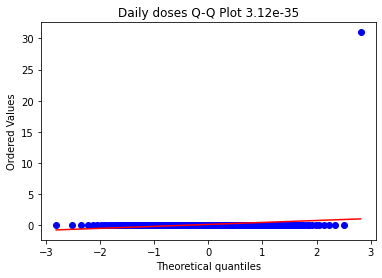

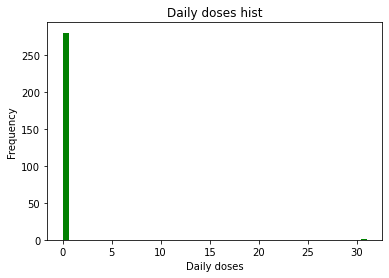

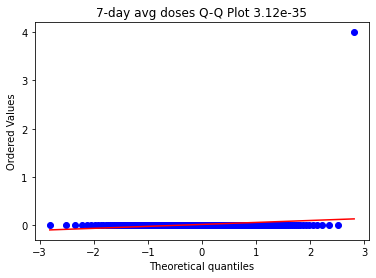

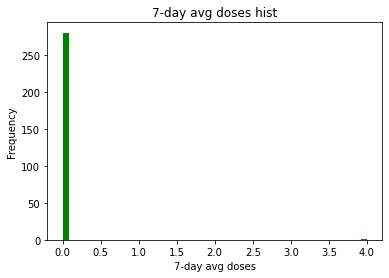

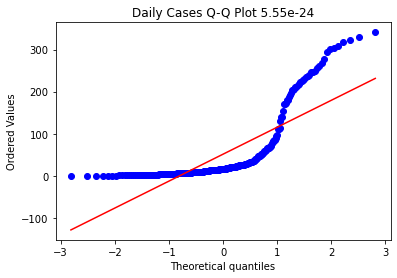

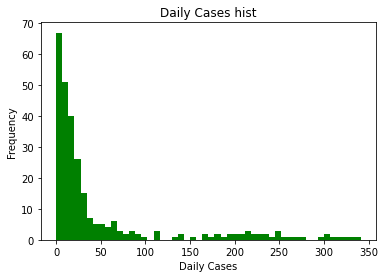

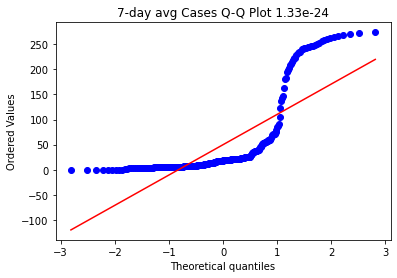

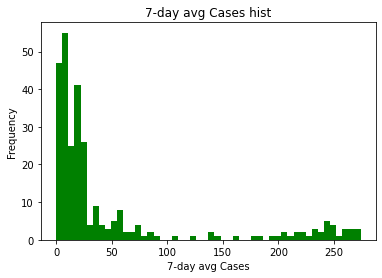

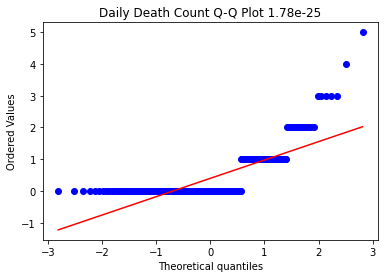

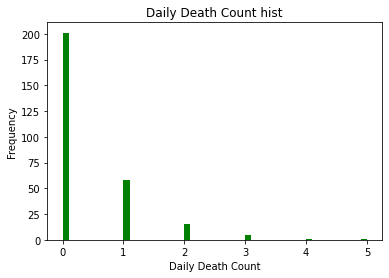

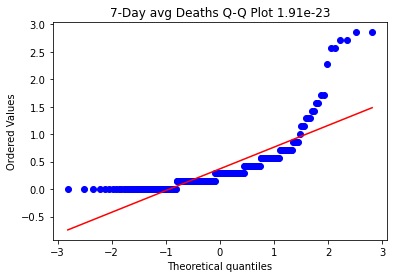

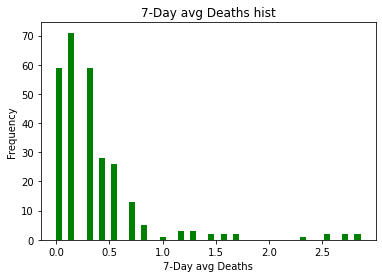

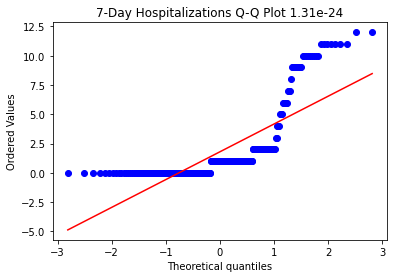

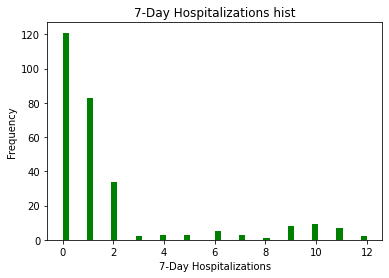

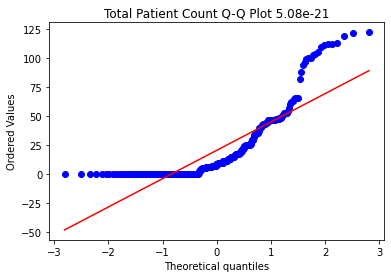

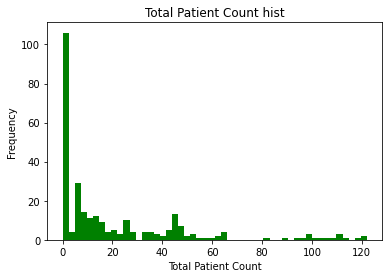

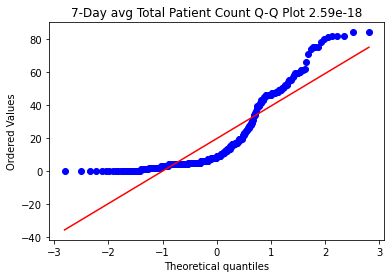

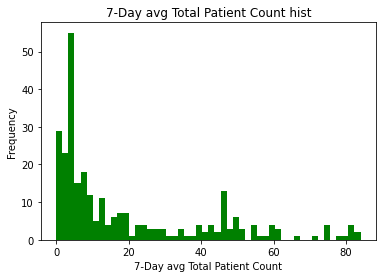

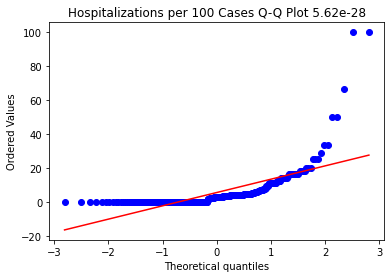

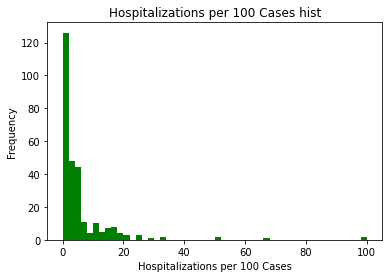

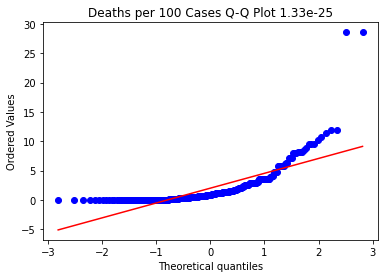

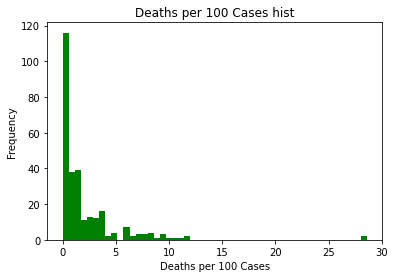

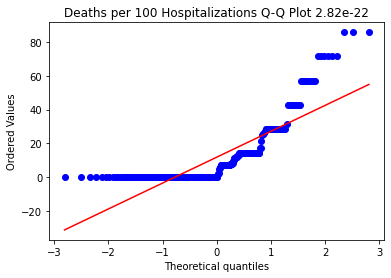

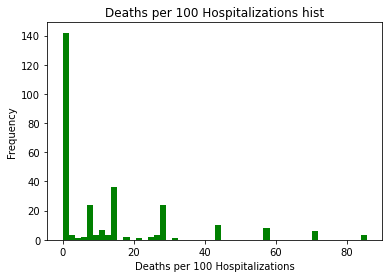

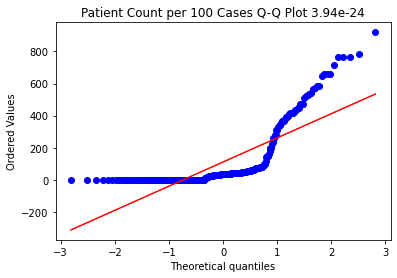

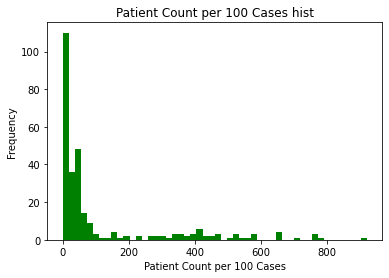

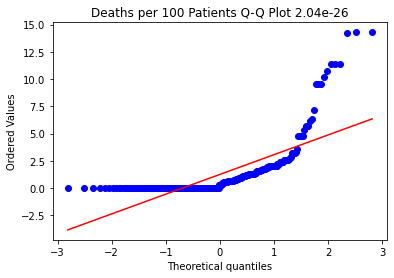

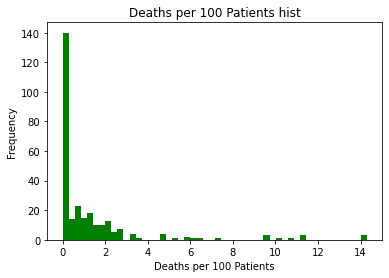

In [107]:
# loop through all the relevant columns and creata a qq plot and histogram for each one because I'm a madman.

for col in pre_group.columns[2:]:
    shapiro_stat = stats.shapiro(pre_group[col])
    stats.probplot(pre_group[col], dist="norm", plot= plt)
    plt.title("{col} Q-Q Plot {pvalue:.3}".format(col = col, pvalue=shapiro_stat.pvalue))
    # plt.savefig("{col} qqplot.png".format(col = col))
    plt.show()
    pre_group[col].plot(kind="hist", title= "{col} hist".format(col=col), color="green", bins=50)
    plt.xlabel("{col}".format(col=col))
    plt.show()


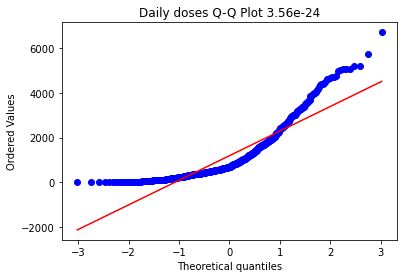

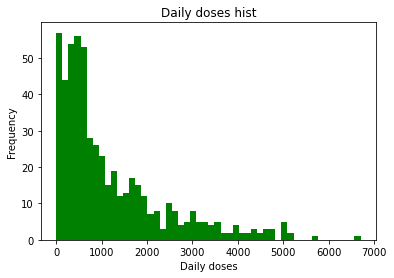

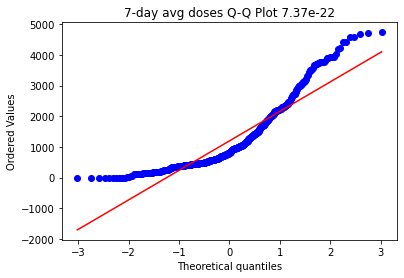

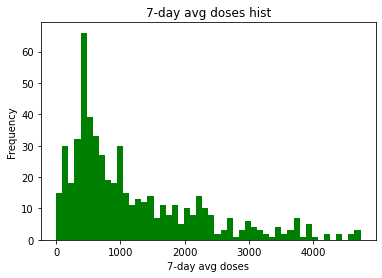

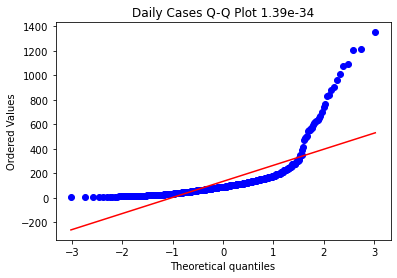

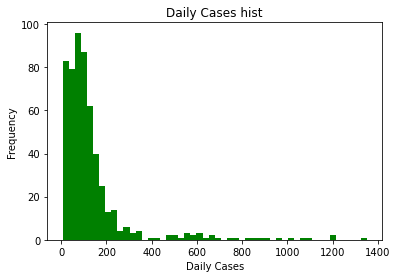

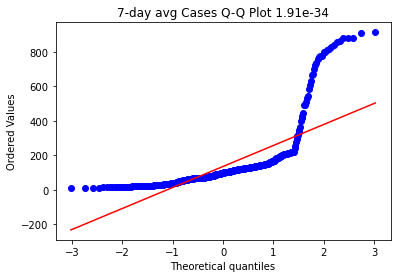

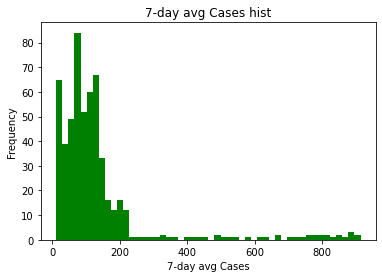

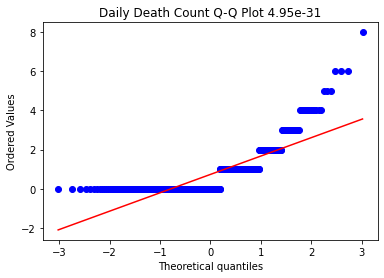

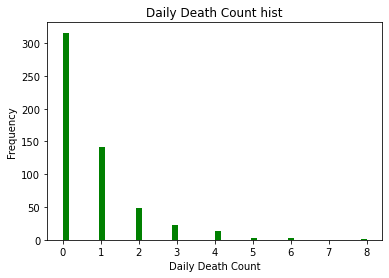

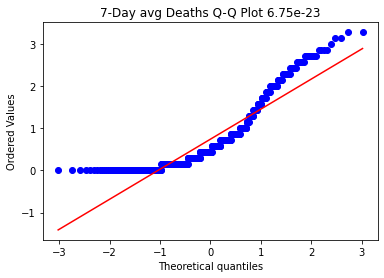

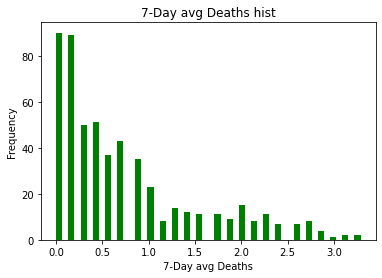

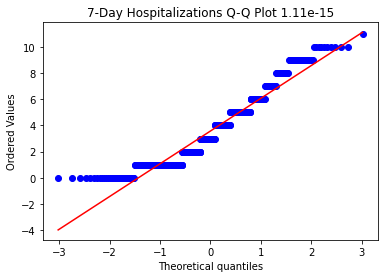

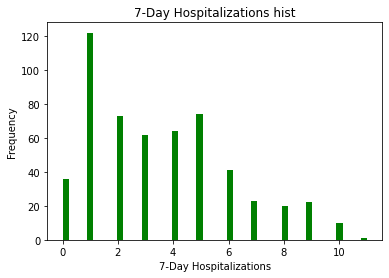

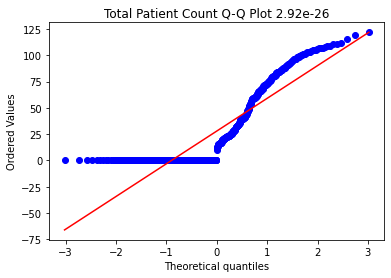

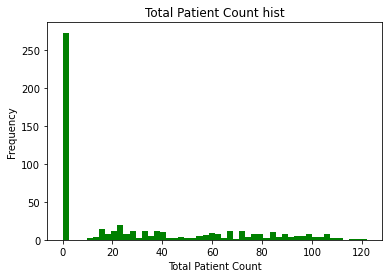

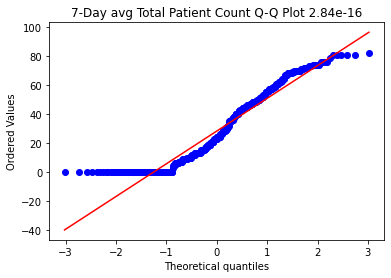

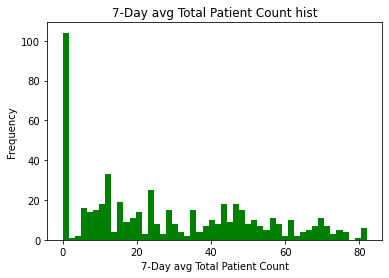

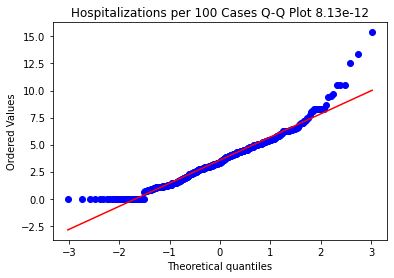

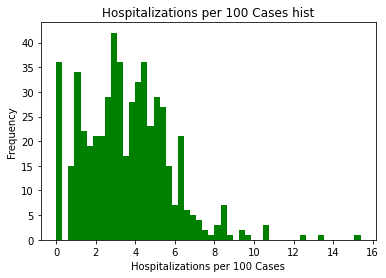

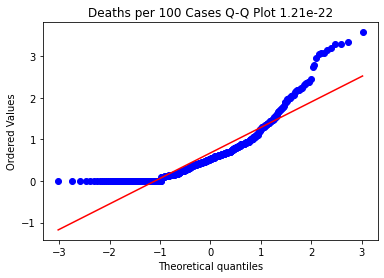

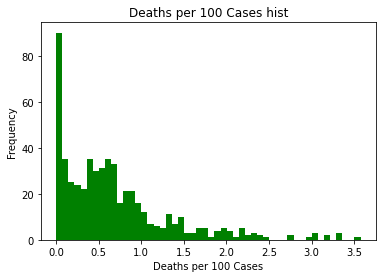

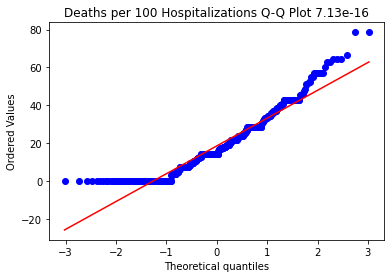

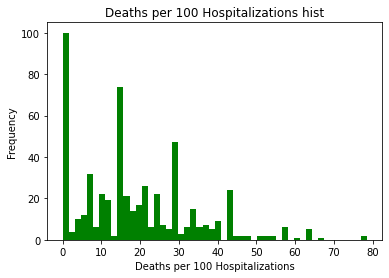

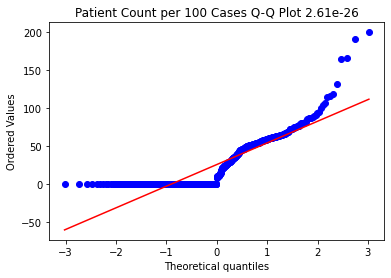

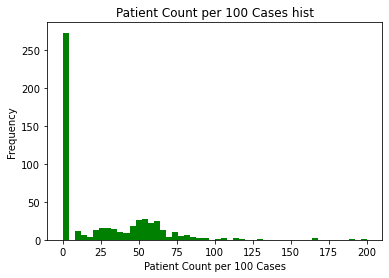

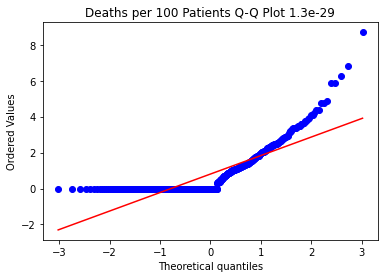

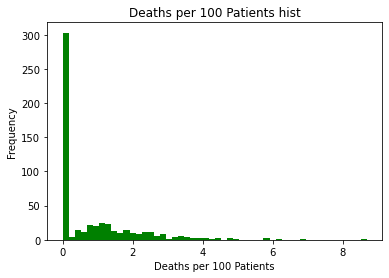

In [108]:
for col in post_group.columns[2:]:
    shapiro_stat = stats.shapiro(post_group[col])
    stats.probplot(post_group[col], dist="norm", plot= plt)
    plt.title("{col} Q-Q Plot {pvalue:.3}".format(col = col, pvalue=shapiro_stat.pvalue))
    # plt.savefig("{col} qqplot.png".format(col = col))
    plt.show()
    post_group[col].plot(kind="hist", title= "{col} hist".format(col=col), color="green", bins=50)
    plt.xlabel("{col}".format(col=col))
    plt.show()

In [109]:
basic_ttest = stats.ttest_ind(pre_group['Daily Cases'], post_group['Daily Cases'], equal_var=False)
print(basic_ttest)

Ttest_indResult(statistic=-9.492664342202687, pvalue=2.393730813462274e-20)


In [110]:
pre_group['Daily Cases']

0        1
1        0
2        0
3        0
4        0
      ... 
276    203
277    228
278    139
279     95
280    111
Name: Daily Cases, Length: 281, dtype: int64

In [111]:
pre_group.columns[4]

'Daily Cases'

In [112]:
# basic_ttest_idex = stats.ttest_ind(pre_group.columns[4], post_group.columns[4], equal_var=False)
# print(basic_ttest_idex)

In [113]:
# for cols1, cols2 in (pre_group.columns[2:], post_group.columns[2:]): 
#     t_test = stats.ttest_ind(cols1, cols2, equal_var=False)
#     print(t_test)

In [114]:
#zip = zip(pre_group.columns[2:],(post_group.columns[2:]))

